# E-Commerce Analysis

# Imports

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

# Functions

In [54]:
def check_nulls_dupes(df):
  print(f"The amount of Null values: {df.isna().sum()}")
  print(f"The amount of Dupe values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(15, 10))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(18, 12))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def create_hist_boxplots(df, interested_columns, type):
  
  plt.figure(figsize=(14, 8))
  rows = len(interested_columns)
  dims = (rows+3)//4

  for idx, col in enumerate(interested_columns):
    plt.subplot(dims, 4, idx+1)
    plt.title(f"Distribution of {col}")
    sns.histplot(df[col], kde=True) if type == "hist" else sns.boxplot(df[col])
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()

def aggregate_views(df, groupy_col, agg_method, interested_columns, figsize):
  
  for col in interested_columns:
    plt.figure(figsize=figsize)
    grouped_df = df.groupby(groupy_col)[col].agg(agg_method).reset_index()
    sns.barplot(data=grouped_df, x=groupy_col, y=col, hue=col)
    plt.title(col)
    plt.xlabel(f"Grouped by : {groupy_col}")
    plt.ylabel(f"Agg by: {col}")
    plt.xticks(rotation=45)
    plt.show()

def plot_model_performance(metric_tracker, sort_col, ascending, axis):
  df = pd.DataFrame(metric_tracker).sort_values(by=sort_col, ascending=ascending).reset_index()
  y = [ col for col in df.columns if col != "Model" and col !="index"]
  
  fig, ax = plt.subplots(figsize=(12,7))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_xlabel("Model")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance")
  plt.legend(y)
  plt.xticks(rotation=45)
  ax.grid(True)
  plt.show()
  
  print(df)
  

def create_pipeline(preprocessor, model):
  
  return Pipeline(
    steps=[
      ("prprocessor", preprocessor),
      ("model", model)
    ]
  )

def create_preprocessor(numeric_features, categorical_features):
  numeric_cols = numeric_features.columns
  categorical_cols = categorical_features.columns
  
  numeric_transformer = Pipeline(
    steps=[
      ("Scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder())
  ])
  
  return ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
  ]
  )

def get_selected_models(names):
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def evaluate_predictions(y, predictions):
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions)
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  
  return [
    acc,
    f1_metric,
    recall_metric,
    precision_metric
  ]

def evaluate_model(model, X, y, scoring_metric):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
  scores = cross_val_score(model, X, y, scoring=scoring_metric, cv=cv, n_jobs=-1)
  preds = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
  pred_scores = evaluate_predictions(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(pred_scores[0],3), 
    round(pred_scores[1], 3), 
    round(pred_scores[2],3),
    round(pred_scores[3],3),
  ]

def test_selected_models(preprocessor, model_names, models, scoring_metric, X, y):
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    pipeline = create_pipeline(preprocessor, model)
    scores = evaluate_model(pipeline, X, y, scoring_metric)

    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[6]
    })
  
  plot_model_performance(metric_tracker, "Test-Acc", False, "Metrics")

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/ecommerce_product_dataset.csv")
df

,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-08
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-26
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-18
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-03
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-08
...,...,...,...,...,...,...,...,...,...,...
995,996,Throw Blanket,Blankets,207.72,2.3,1973,16,0.46,325,2024-02-11
996,997,Fleece Blanket,Blankets,268.60,3.2,841,201,0.39,1546,2023-06-29
997,998,Throw Blanket,Blankets,92.74,2.8,3454,880,0.02,1295,2023-10-27
998,999,Weighted Blanket,Blankets,152.28,1.3,2850,752,0.34,1962,2023-10-26


# Check For Nulls and Dupes

In [4]:
check_nulls_dupes(df)

The amount of Null values: ProductID        0
ProductName      0
Category         0
Price            0
Rating           0
NumReviews       0
StockQuantity    0
Discount         0
Sales            0
DateAdded        0
dtype: int64
The amount of Dupe values: 0


# Check Class Imbalance

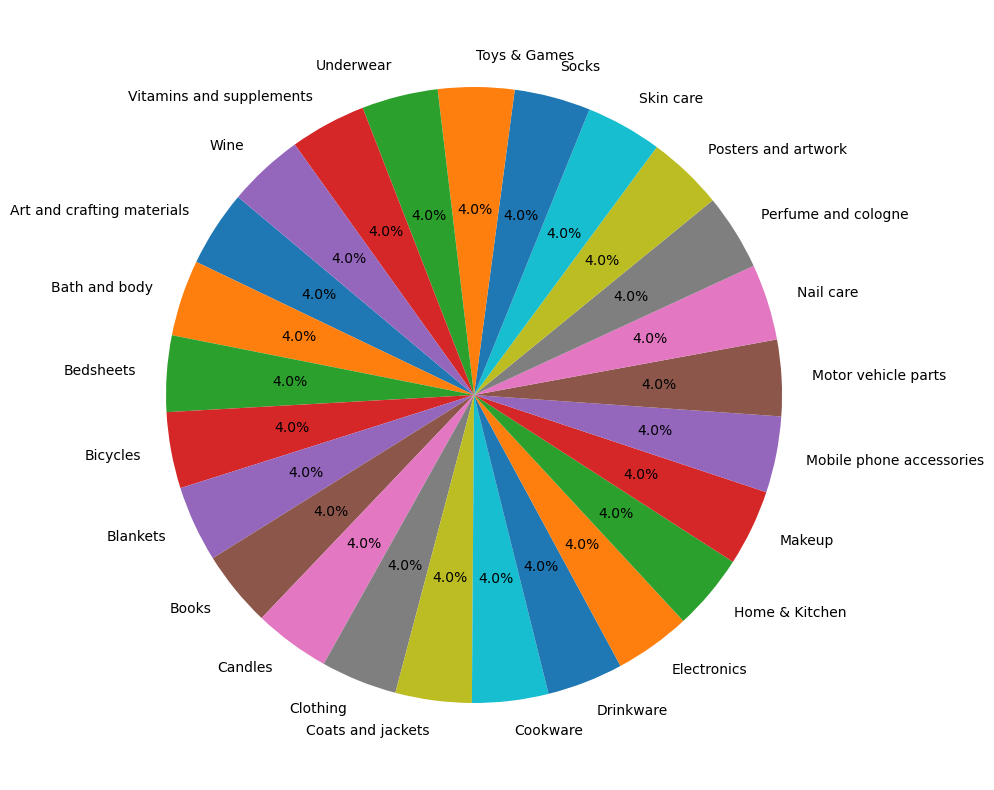

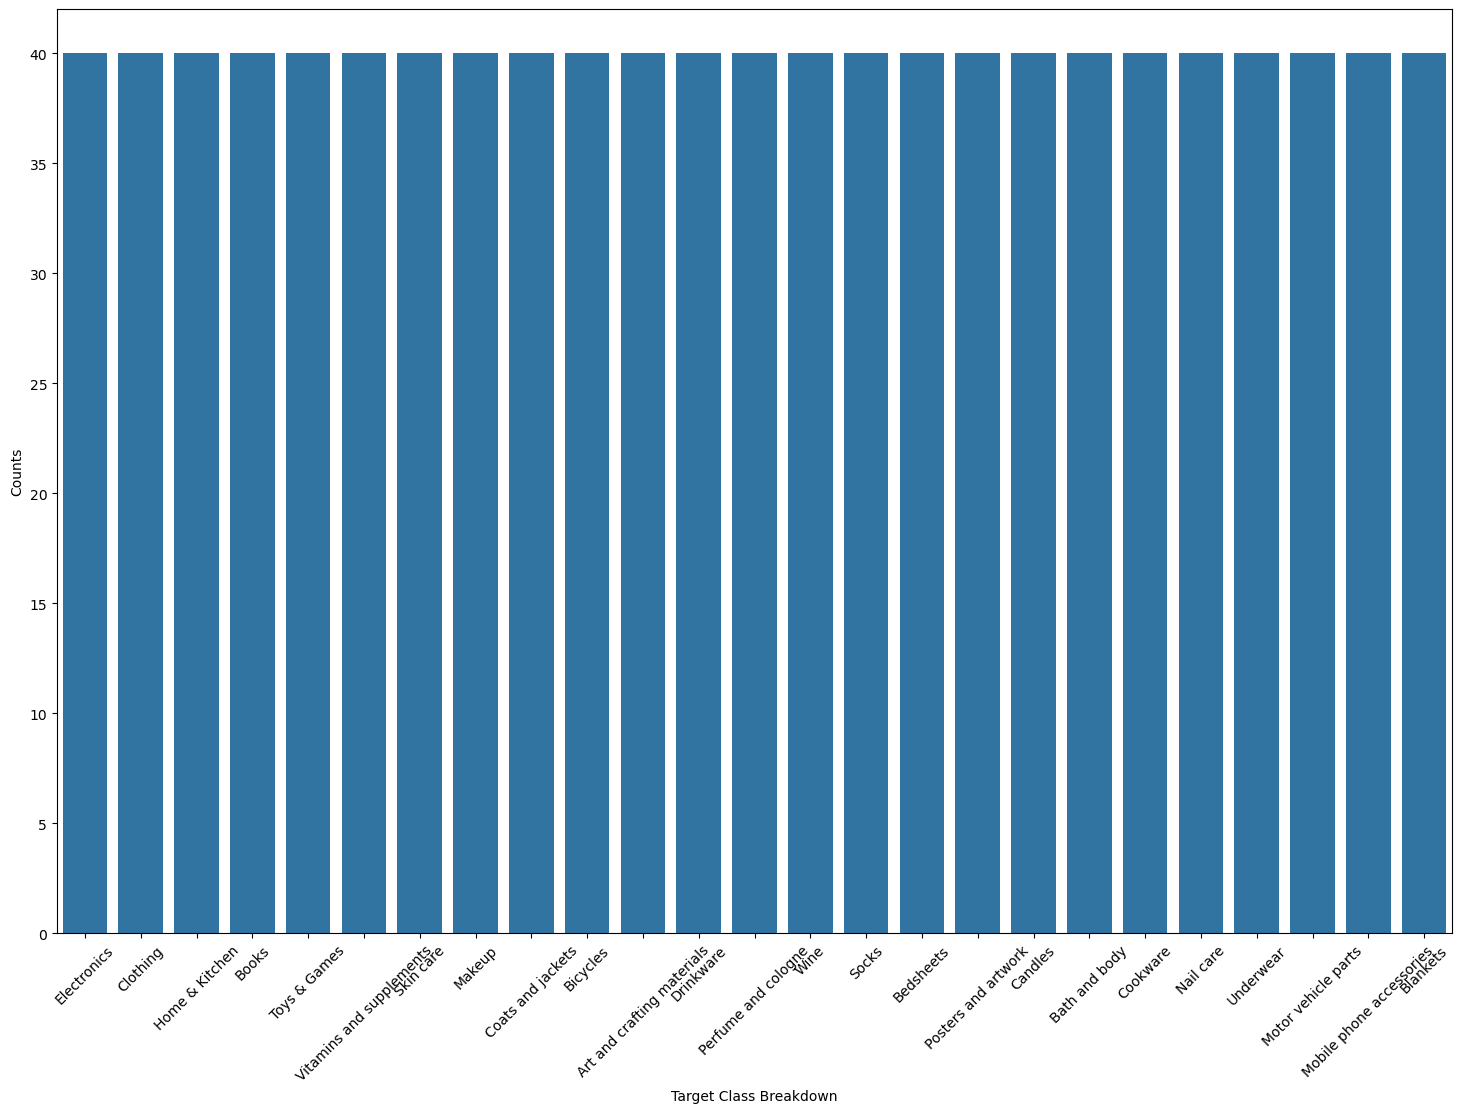

In [5]:
check_class_imbalance(df["Category"])

# We Have a Category Balance

# I think we might be able to narrow the amount of categories down into smaller categories, maybe for health, home, etc. We will have to explore this after some eda analysis

In [6]:
df.dtypes

ProductID          int64
ProductName       object
Category          object
Price            float64
Rating           float64
NumReviews         int64
StockQuantity      int64
Discount         float64
Sales              int64
DateAdded         object
dtype: object

In [7]:
df.describe()

,ProductID,Price,Rating,NumReviews,StockQuantity,Discount,Sales
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,253.77551,3.025600,2498.753000,495.395000,0.251640,1011.037000
std,288.819436,141.40362,1.151004,1463.241871,292.799253,0.146455,582.113466
min,1.000000,10.11000,1.000000,3.000000,0.000000,0.000000,0.000000
25%,250.750000,133.09250,2.100000,1201.750000,241.750000,0.130000,502.000000
50%,500.500000,251.31000,3.100000,2476.000000,505.000000,0.250000,998.000000
75%,750.250000,375.82750,4.000000,3797.500000,743.500000,0.380000,1540.000000
max,1000.000000,499.74000,5.000000,4994.000000,993.000000,0.500000,1997.000000


In [8]:
df.drop("ProductID", axis=1, inplace=True)

In [9]:
df["ProductName"].value_counts()

Biography        22
Mountain Bike    19
Throw Blanket    18
Denim Jacket     17
Vitamin D        15
                 ..
Rain Jacket       5
Winter Coat       5
Cuticle Oil       5
Fantasy Book      4
Pillar Candle     4
Name: ProductName, Length: 100, dtype: int64

In [10]:
df.drop("ProductName", axis=1, inplace=True)

# Change Object column to Datetime

In [11]:
df["DateAdded"] = pd.to_datetime(df["DateAdded"])
columns = ["year", "day", "month"]

for col in columns:
  df[col] = getattr(df["DateAdded"].dt, col)

In [12]:
df.drop("DateAdded", inplace=True, axis=1)

df["year"].value_counts()

2023    575
2024    425
Name: year, dtype: int64

# Visual Analysis

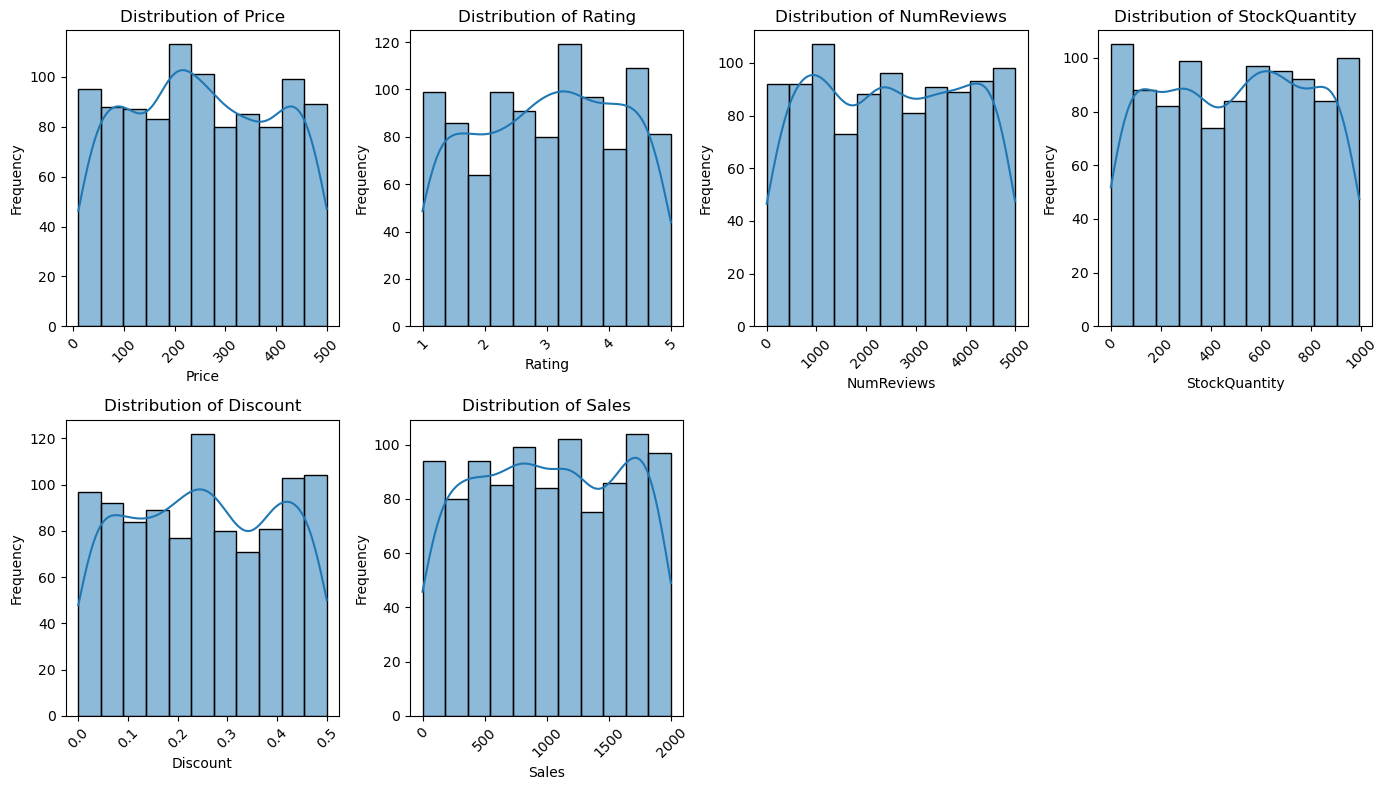

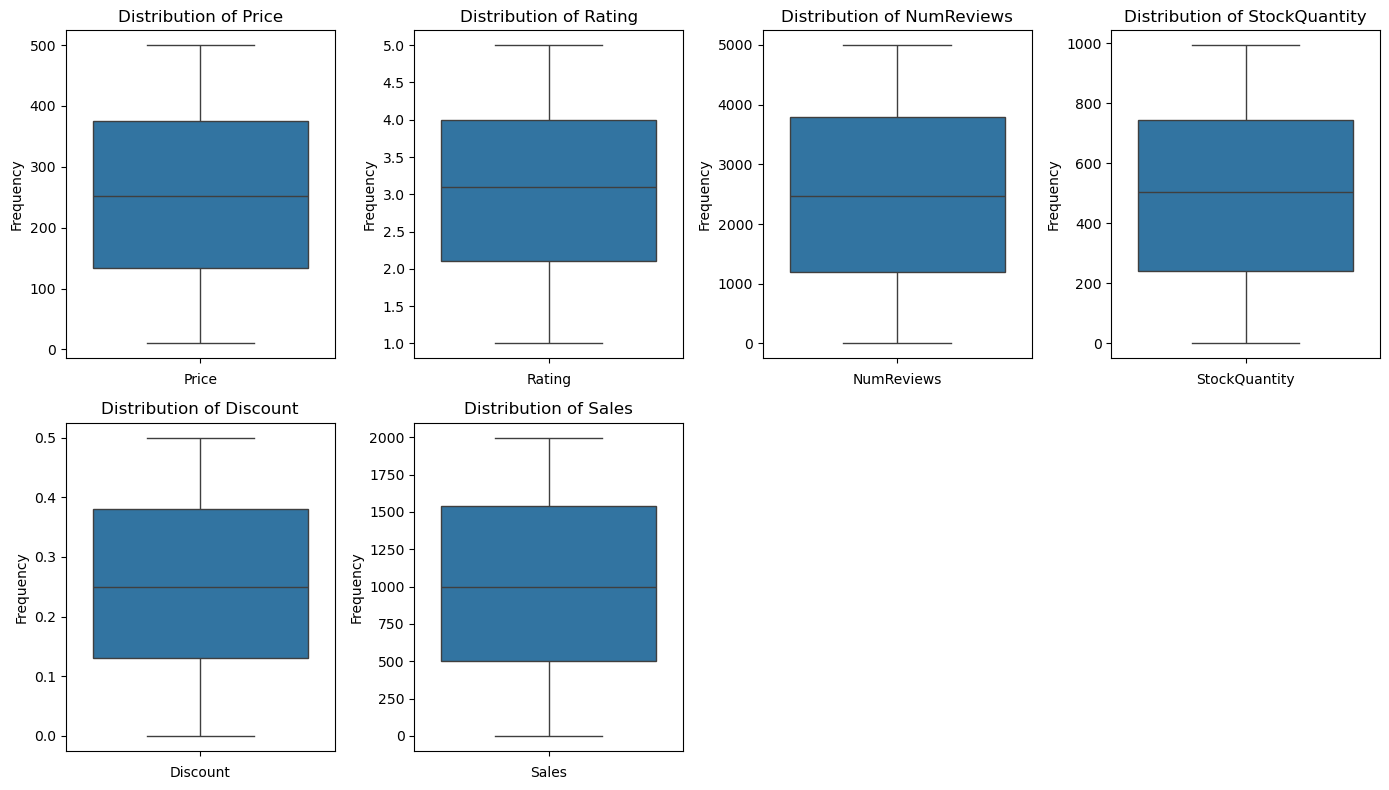

In [13]:
interested_columns = ["Price", "Rating", "NumReviews", "StockQuantity", "Discount", "Sales"]

create_hist_boxplots(df, interested_columns, "hist")
create_hist_boxplots(df, interested_columns, "box")

# Create Numeric and Categorical Features

In [14]:
numeric_features = df.select_dtypes(include=["int64", "float64"])
categorical_features = df.select_dtypes(include=["object"])

# Heatmap

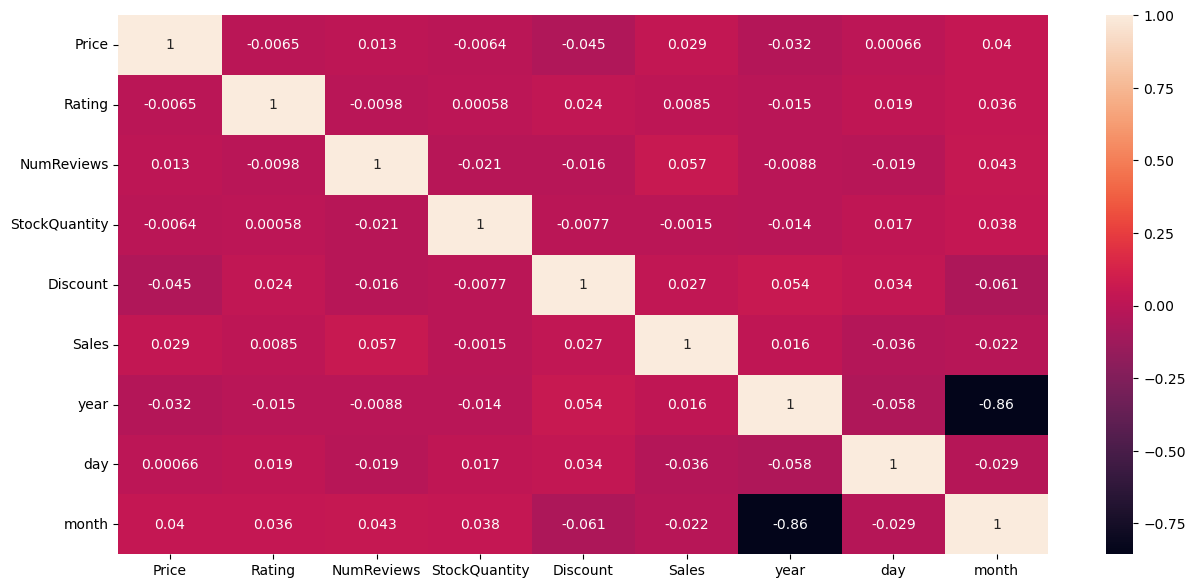

In [15]:
relations = numeric_features.corr()
plt.figure(figsize=(15, 7))
sns.heatmap(data=relations, annot=True)
plt.show()

# Year Sum Visuals

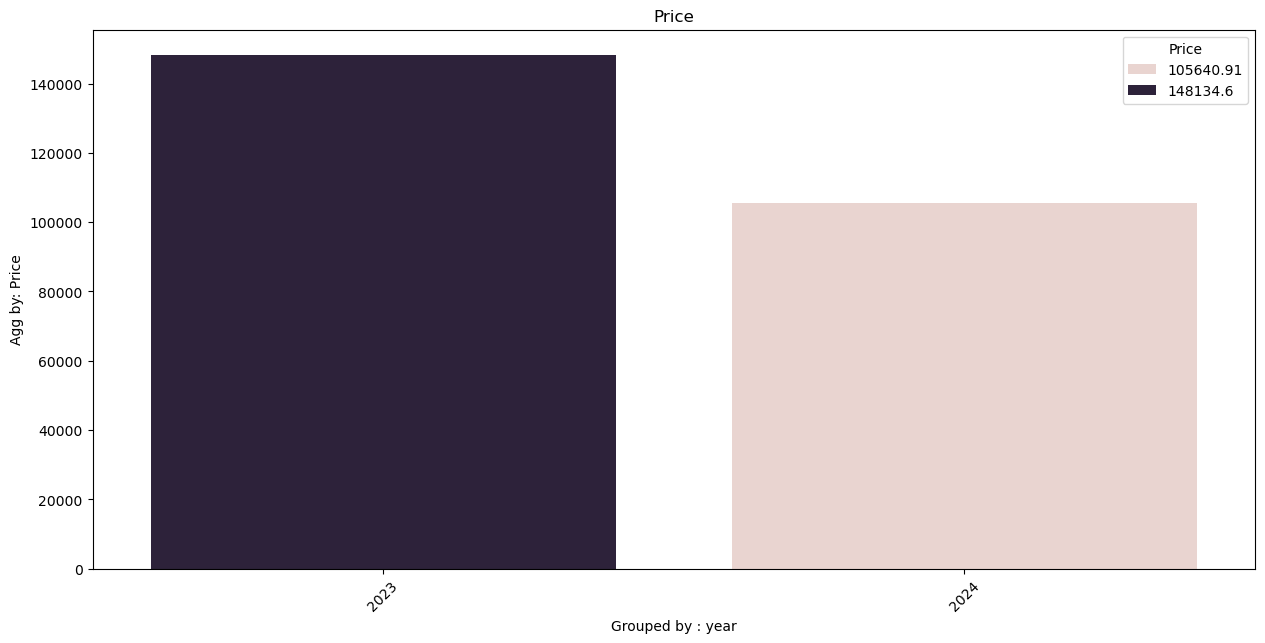

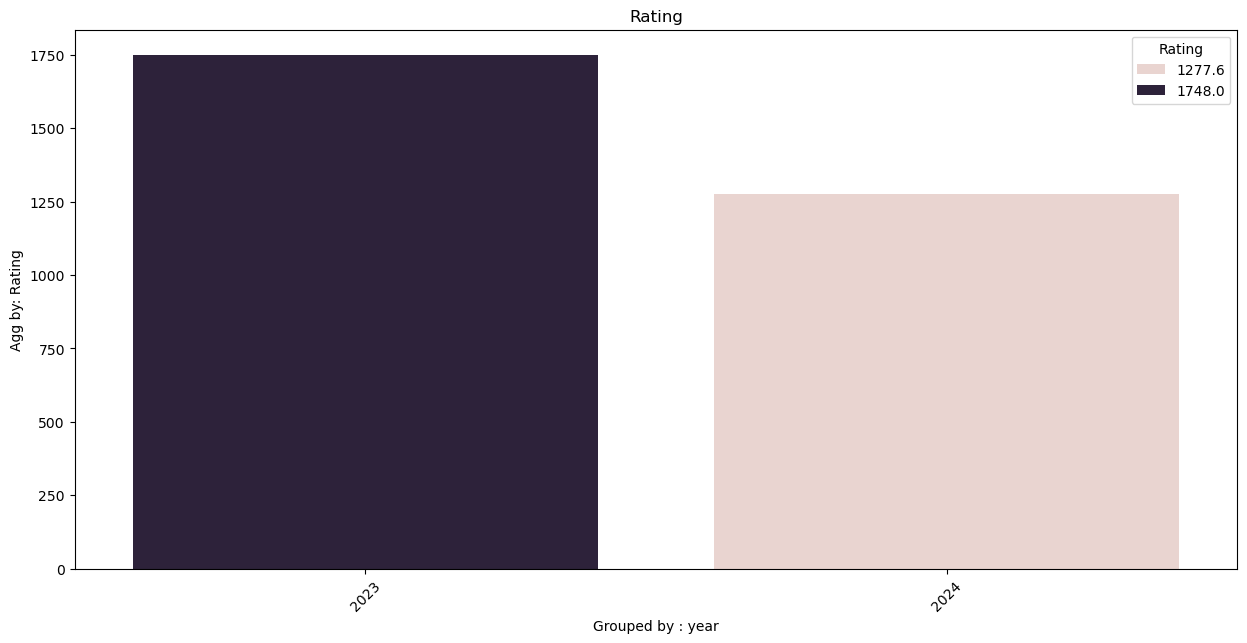

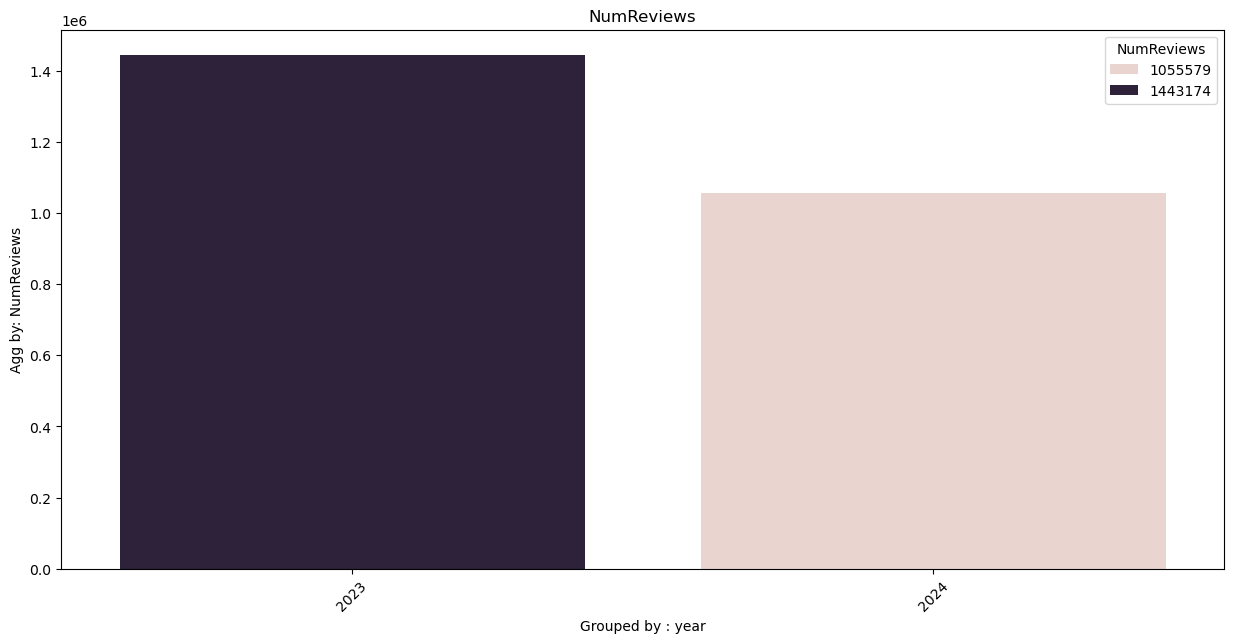

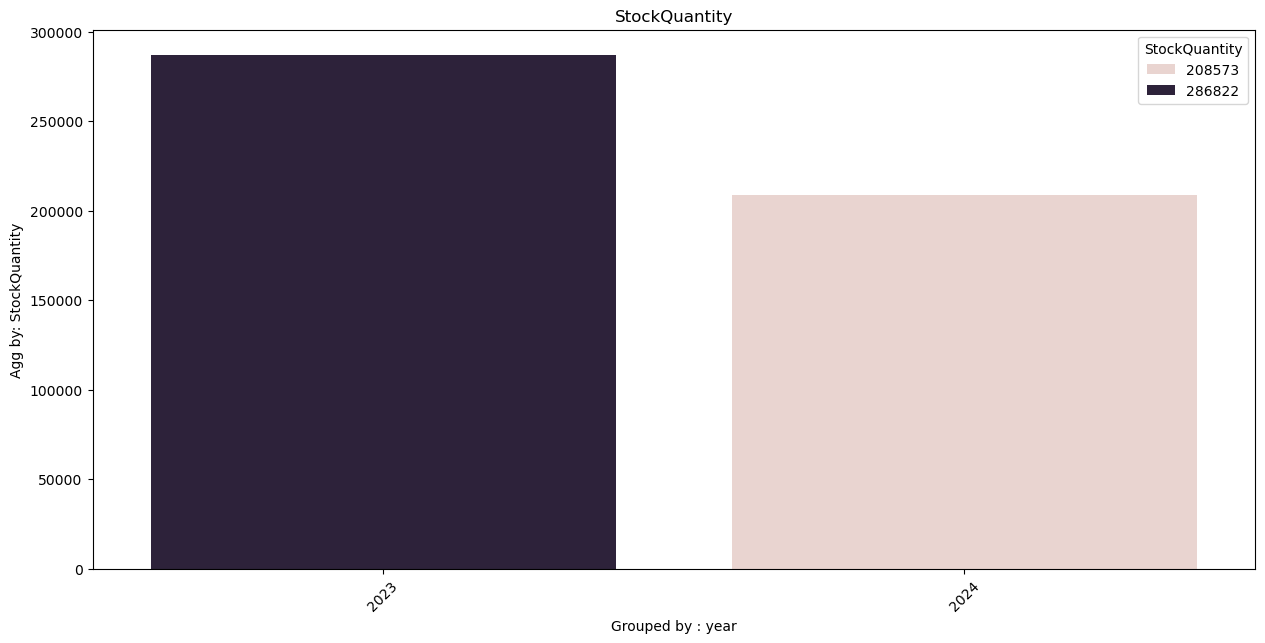

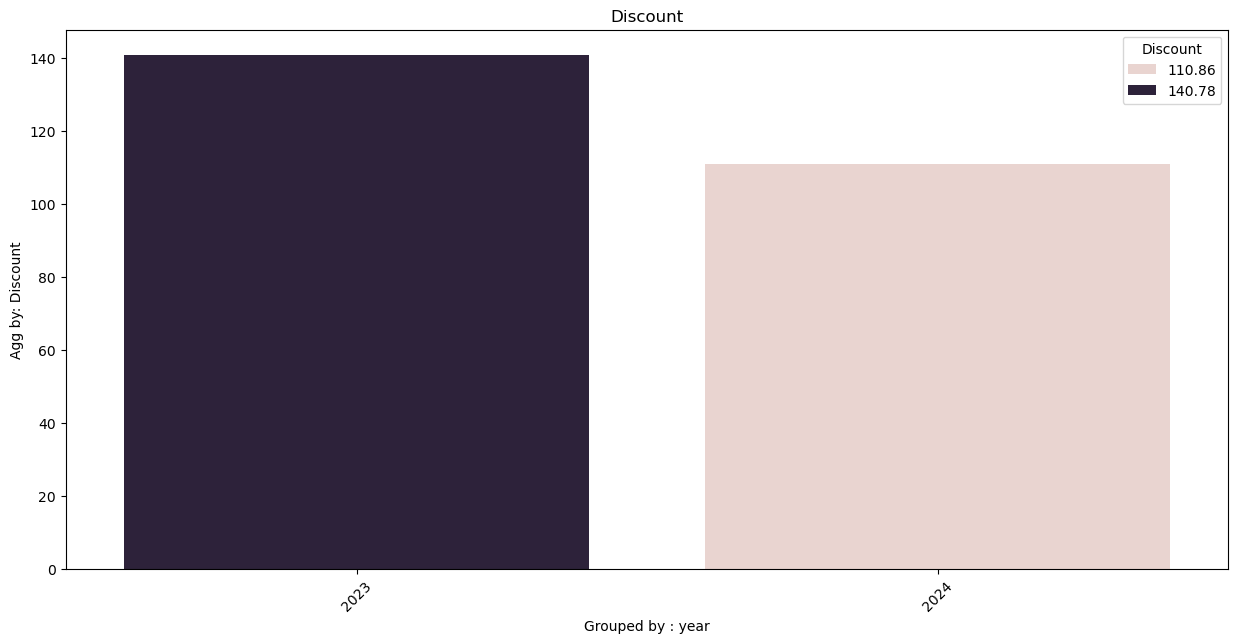

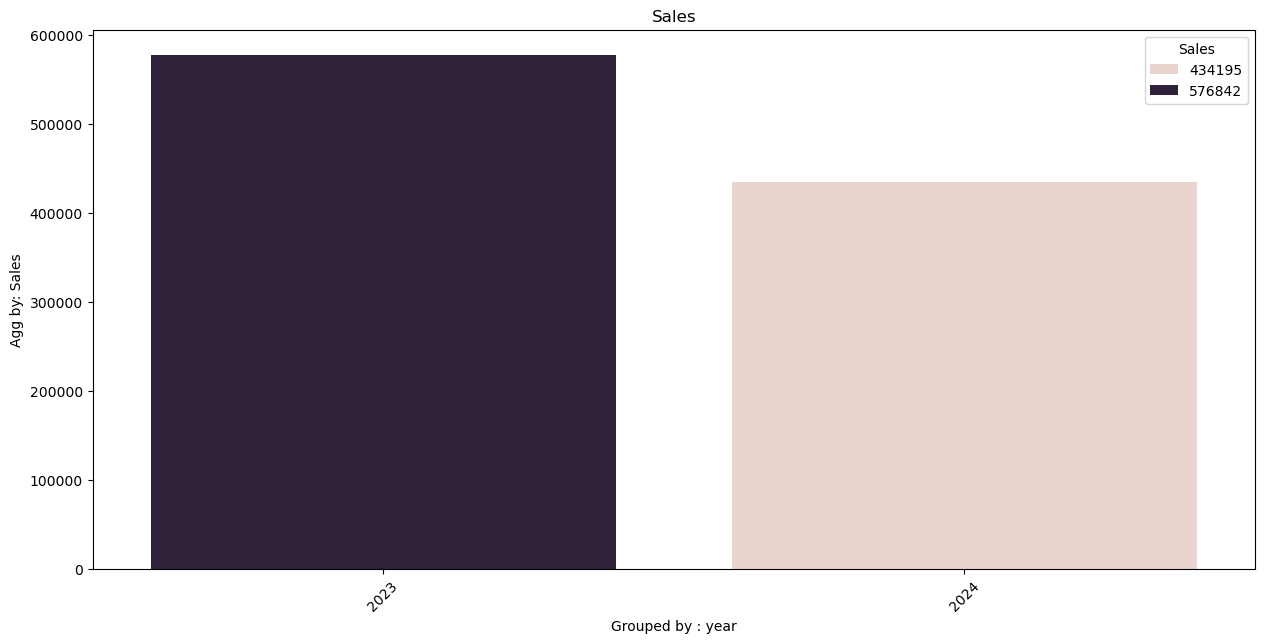

In [16]:
aggregate_views(df, "year", "sum", interested_columns, (15, 7))

# Year Mean Grouping

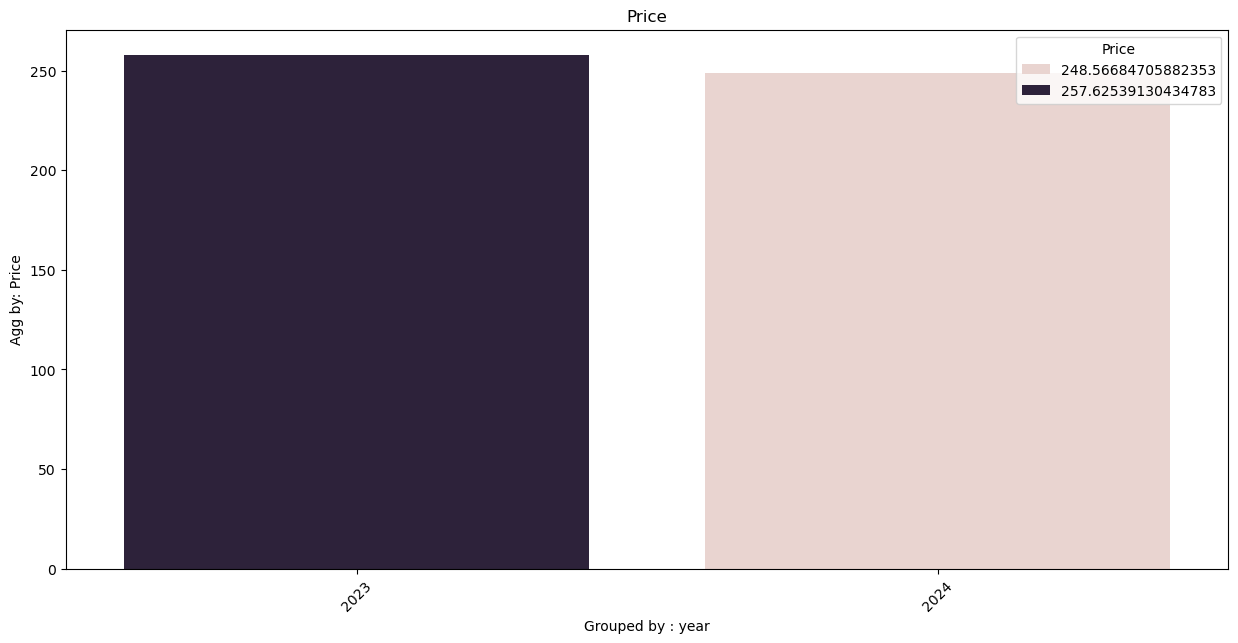

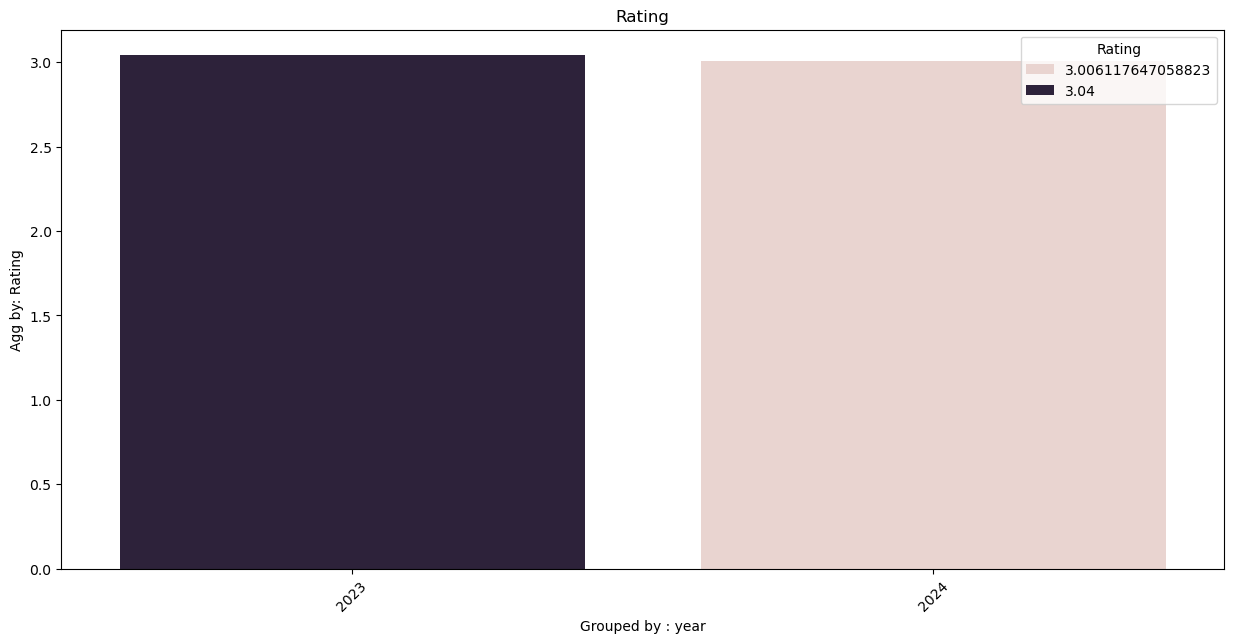

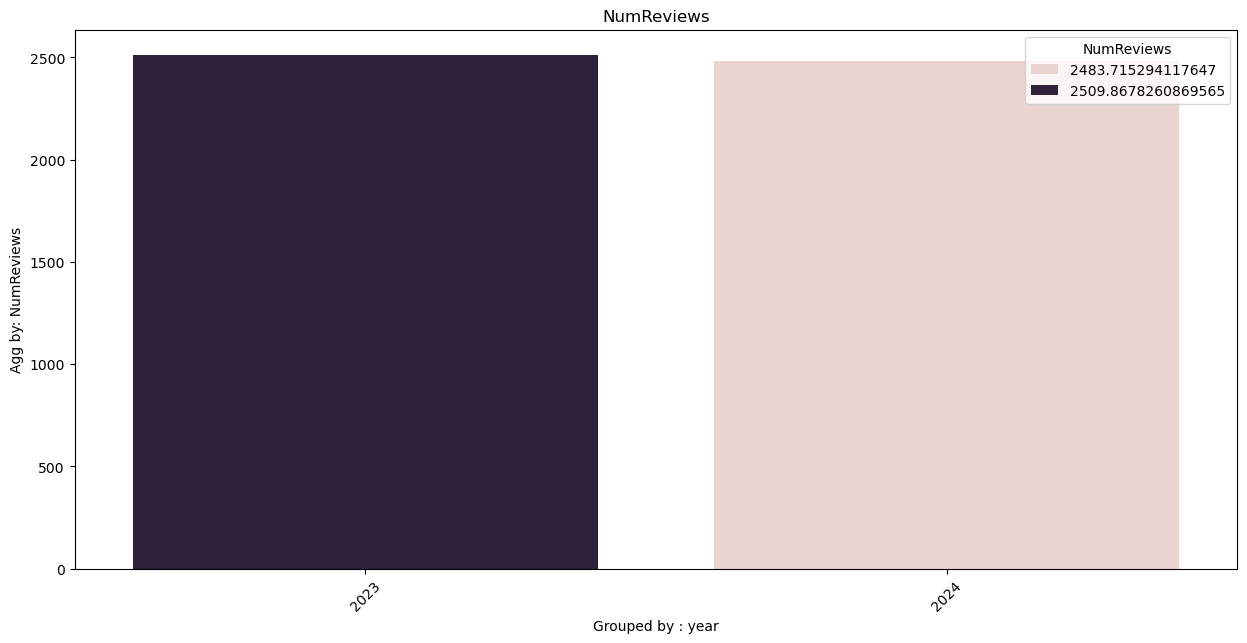

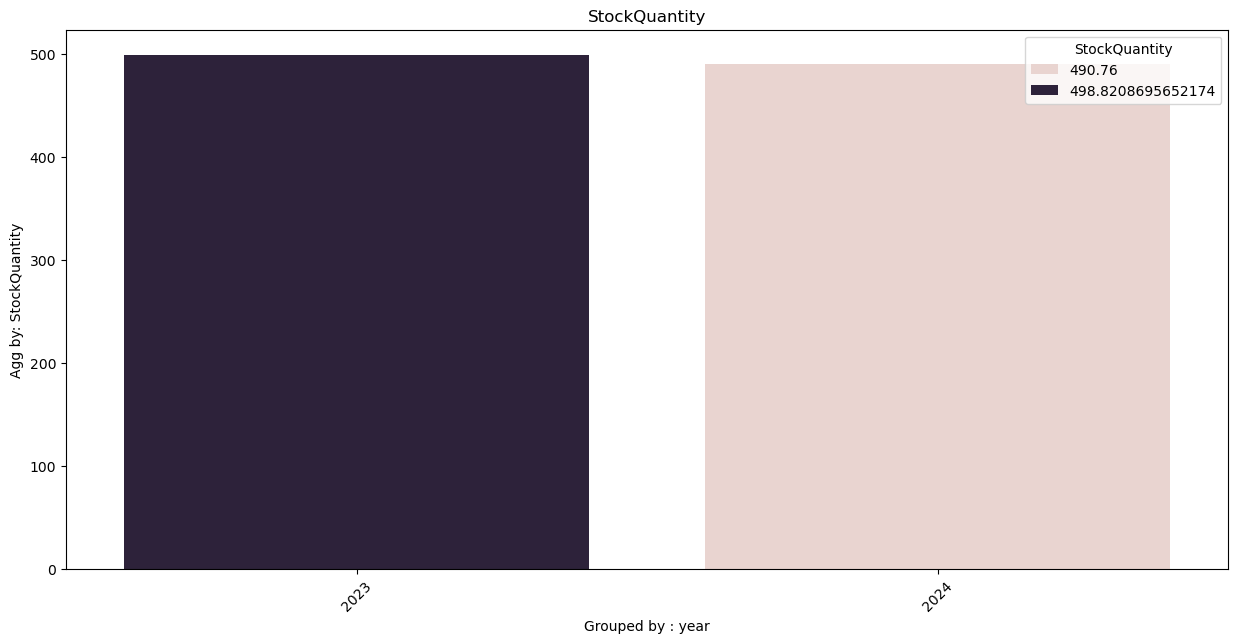

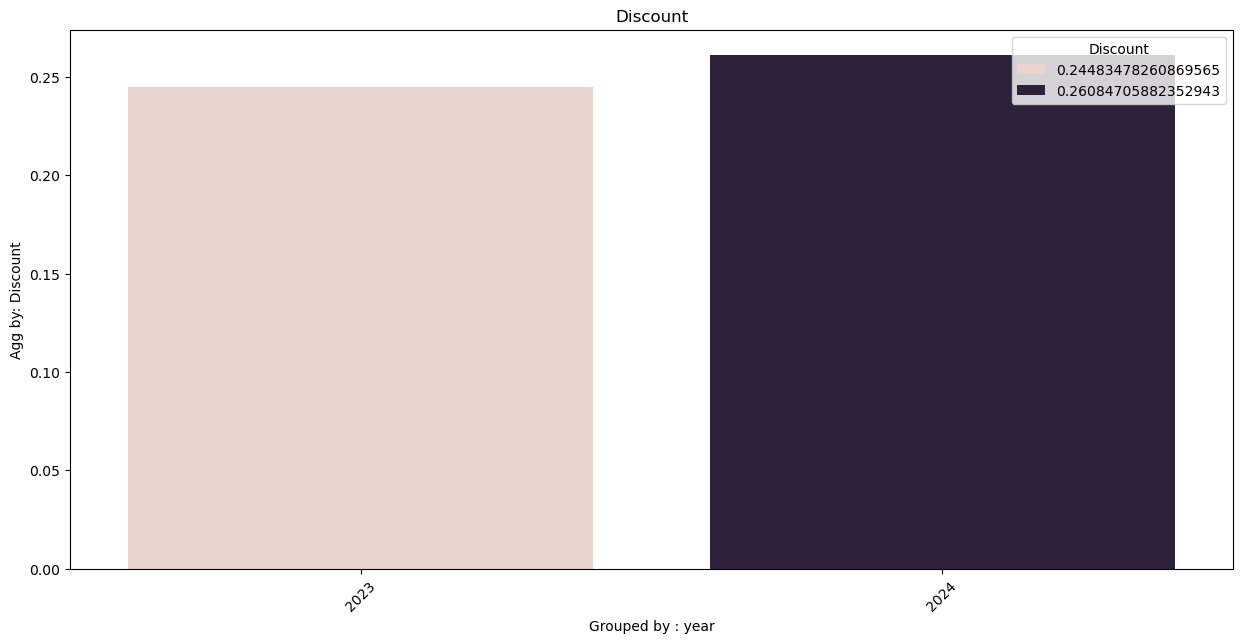

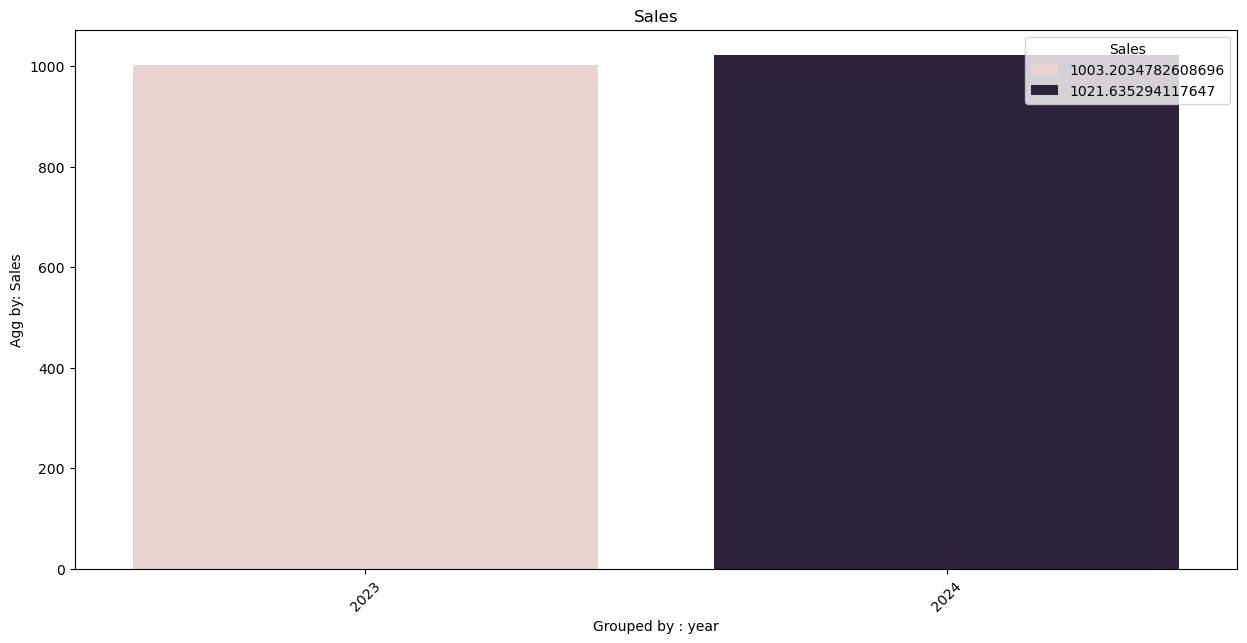

In [17]:
aggregate_views(df, "year", "mean", interested_columns, (15, 7))

# Month Mean Grouping

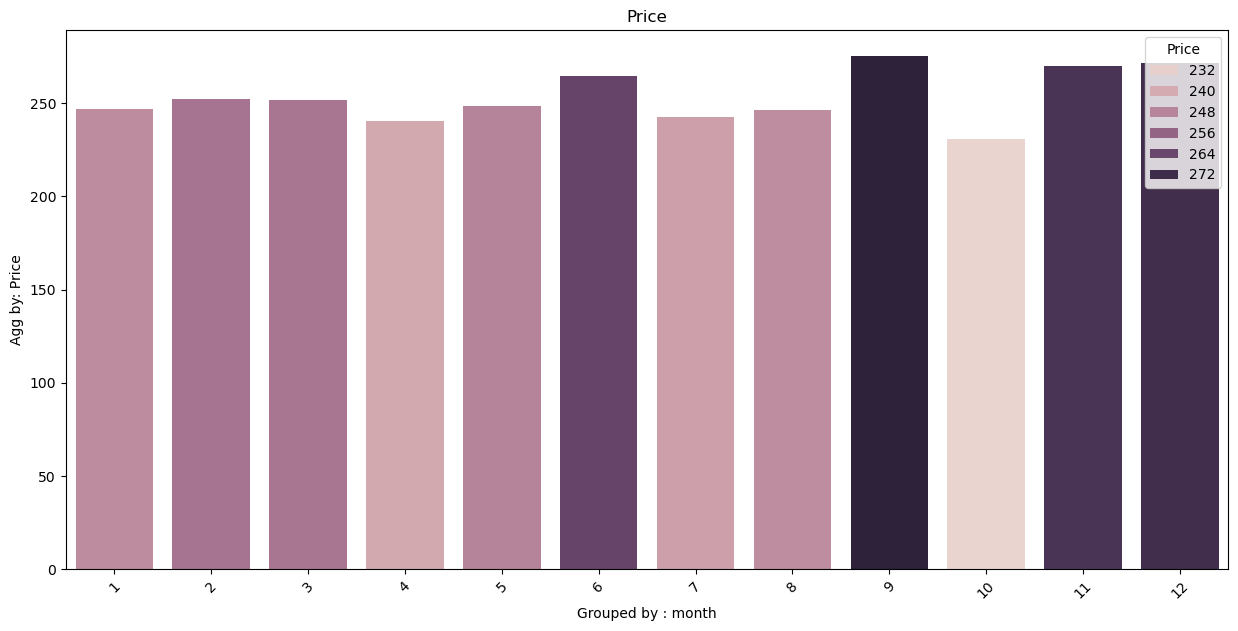

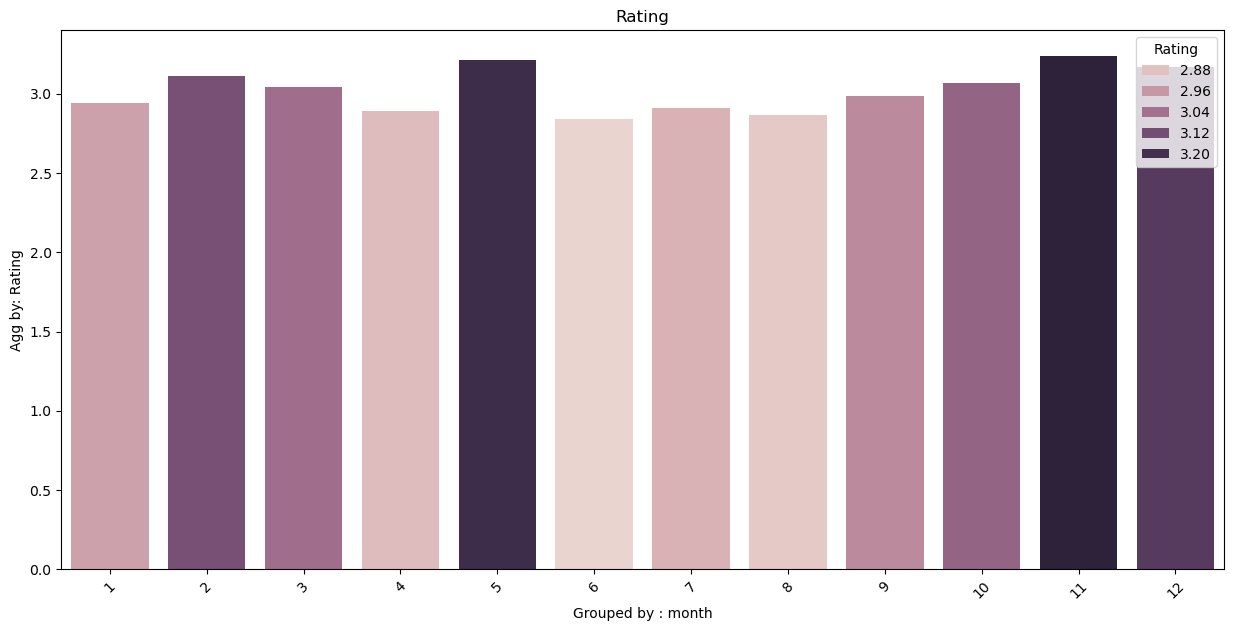

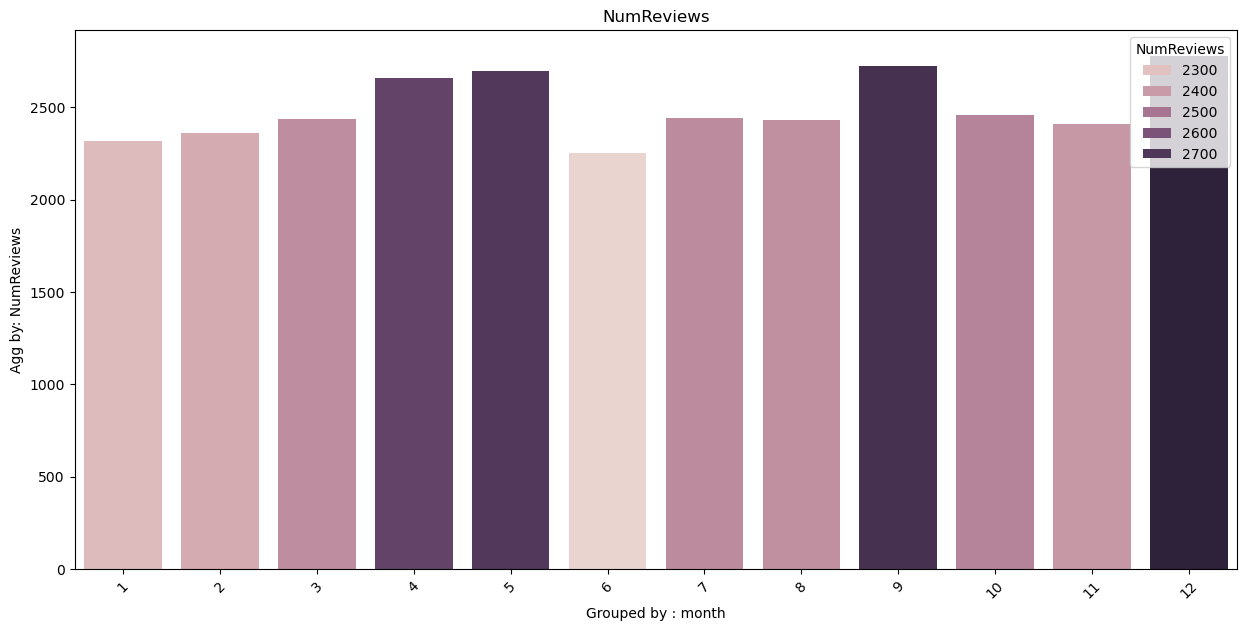

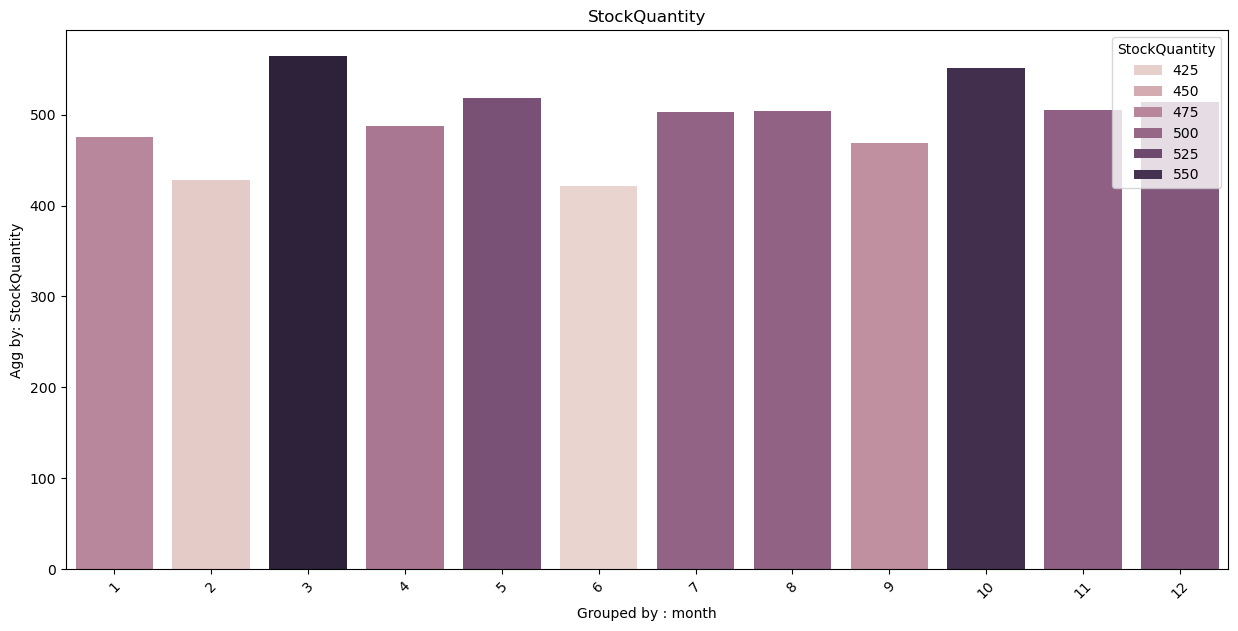

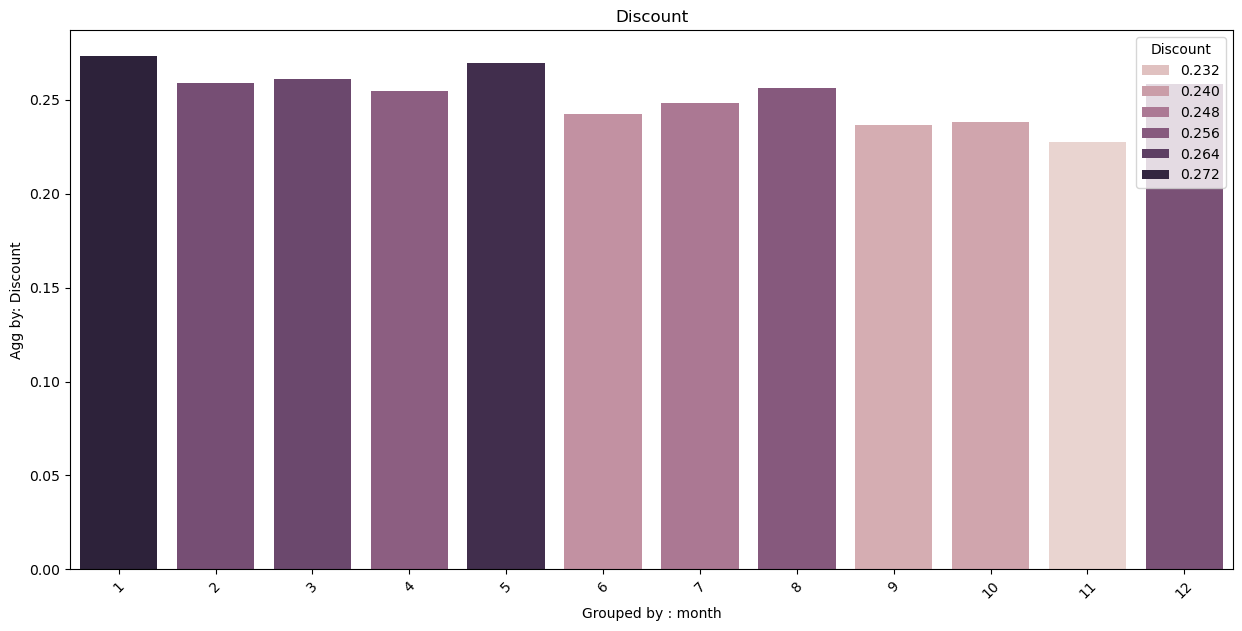

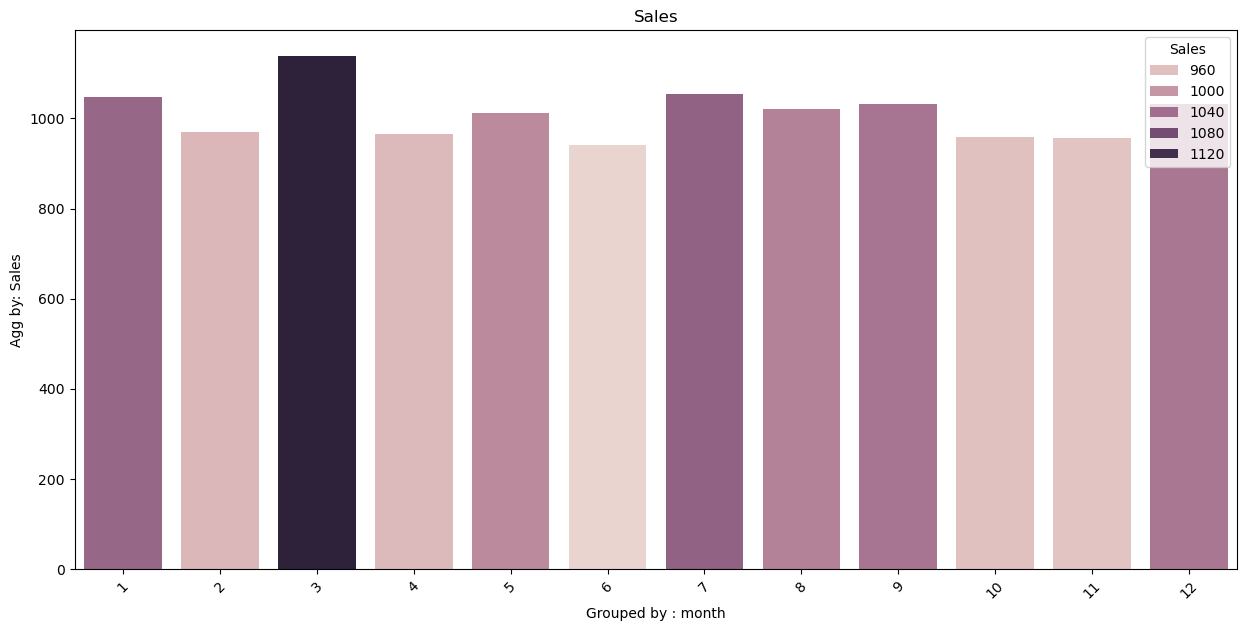

In [18]:
aggregate_views(df, "month", "mean", interested_columns, (15, 7))

# Month Sum Grouping

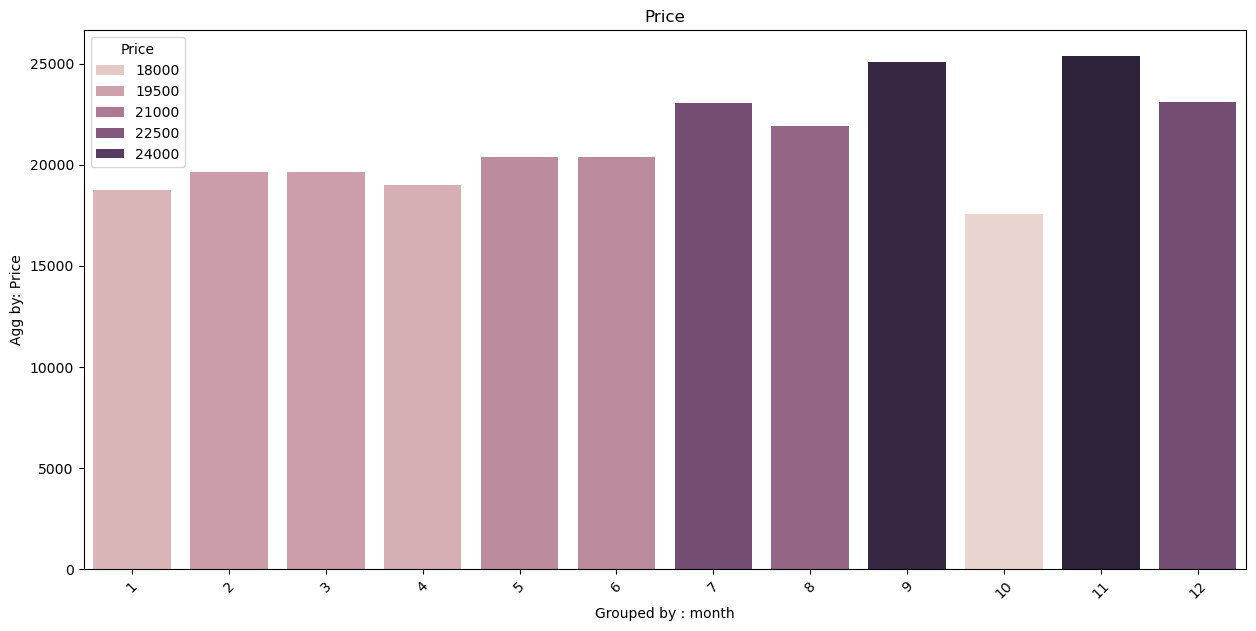

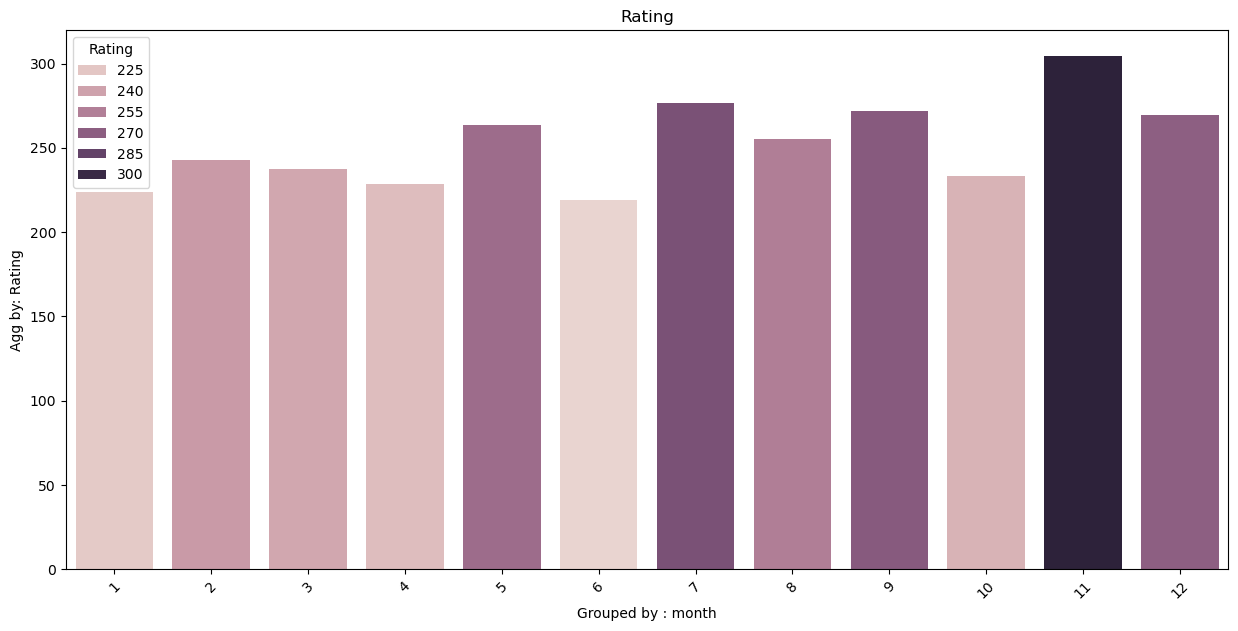

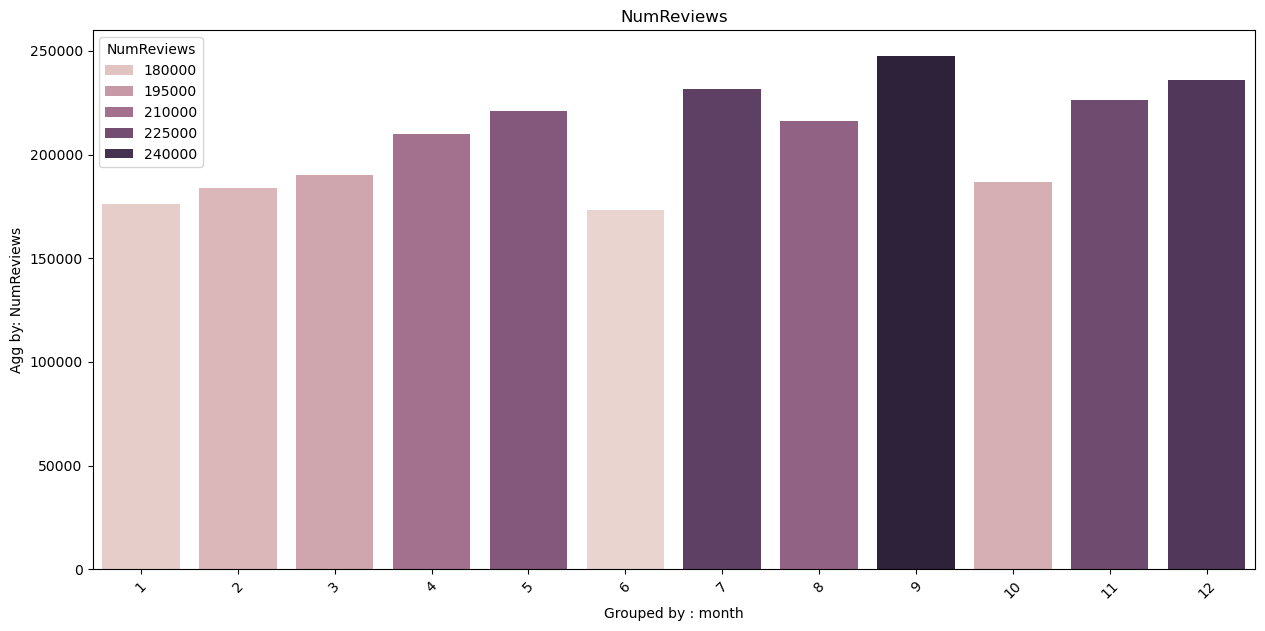

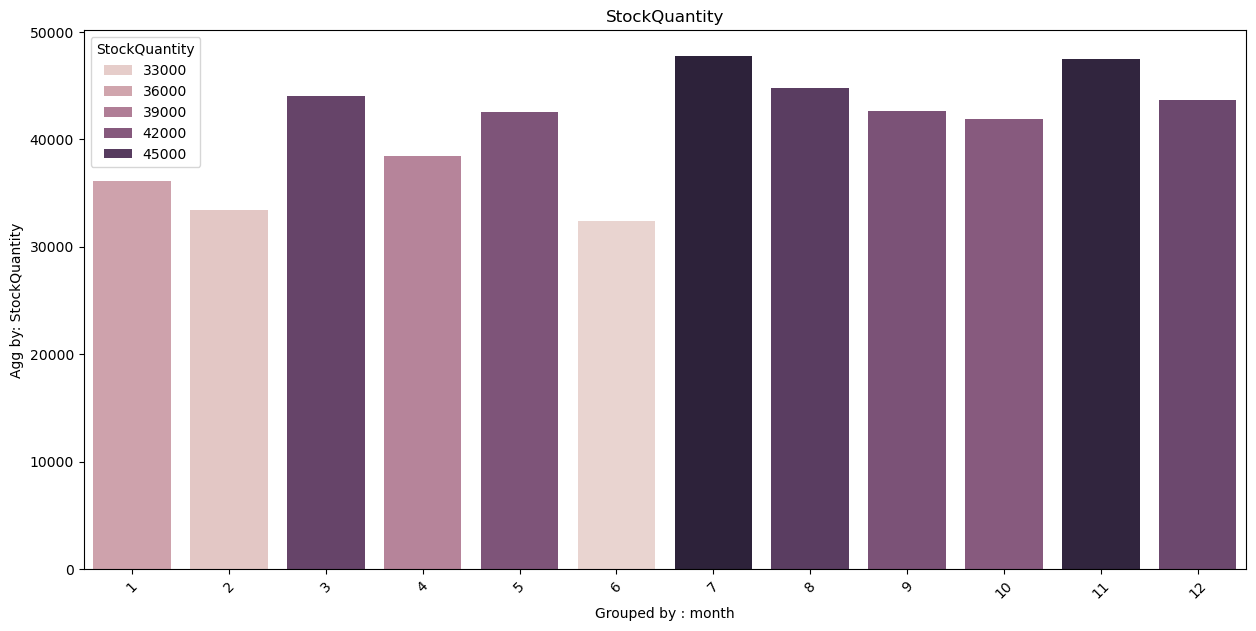

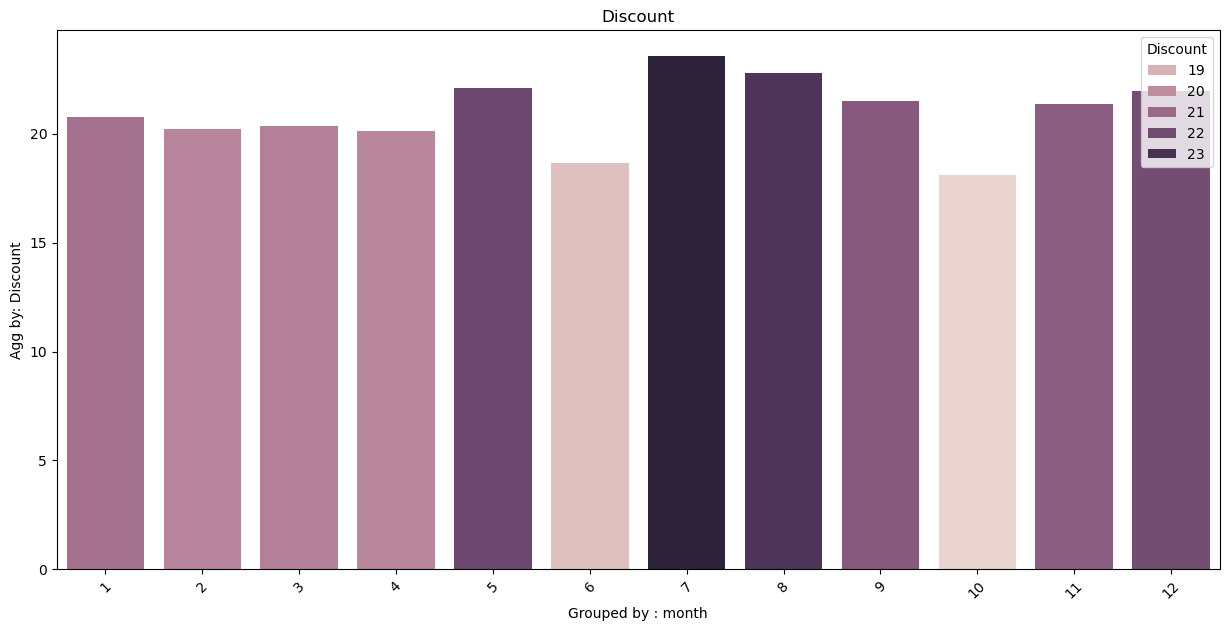

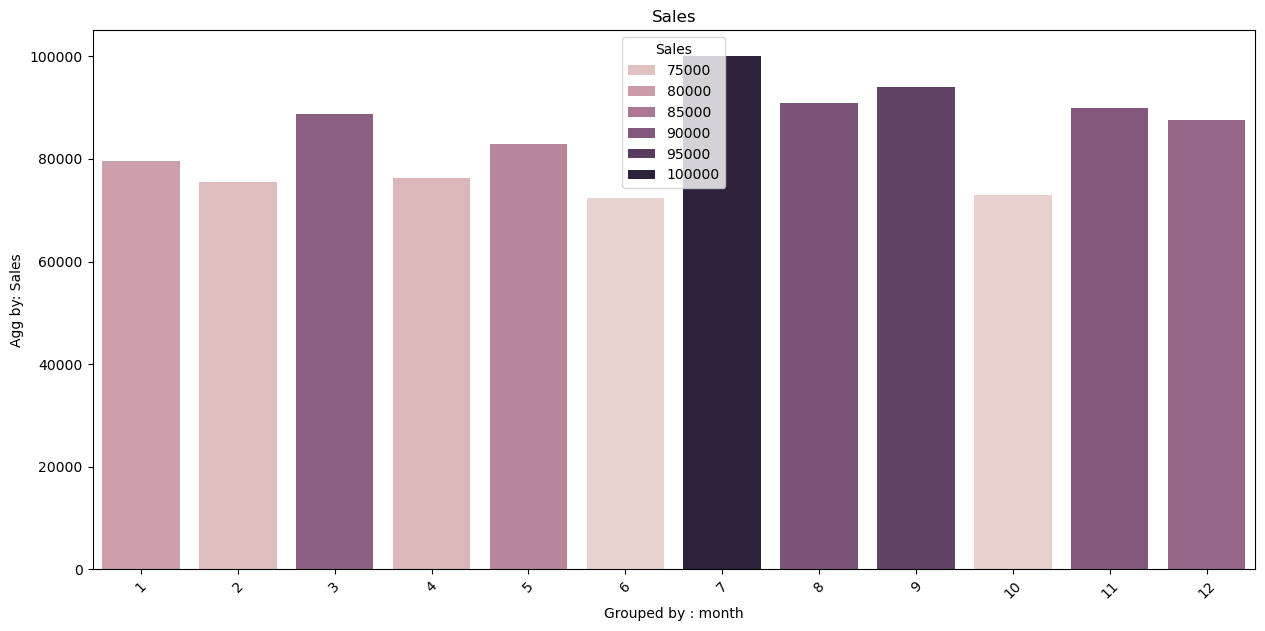

In [19]:
aggregate_views(df, "month", "sum", interested_columns, (15, 7))

# Category Grouping

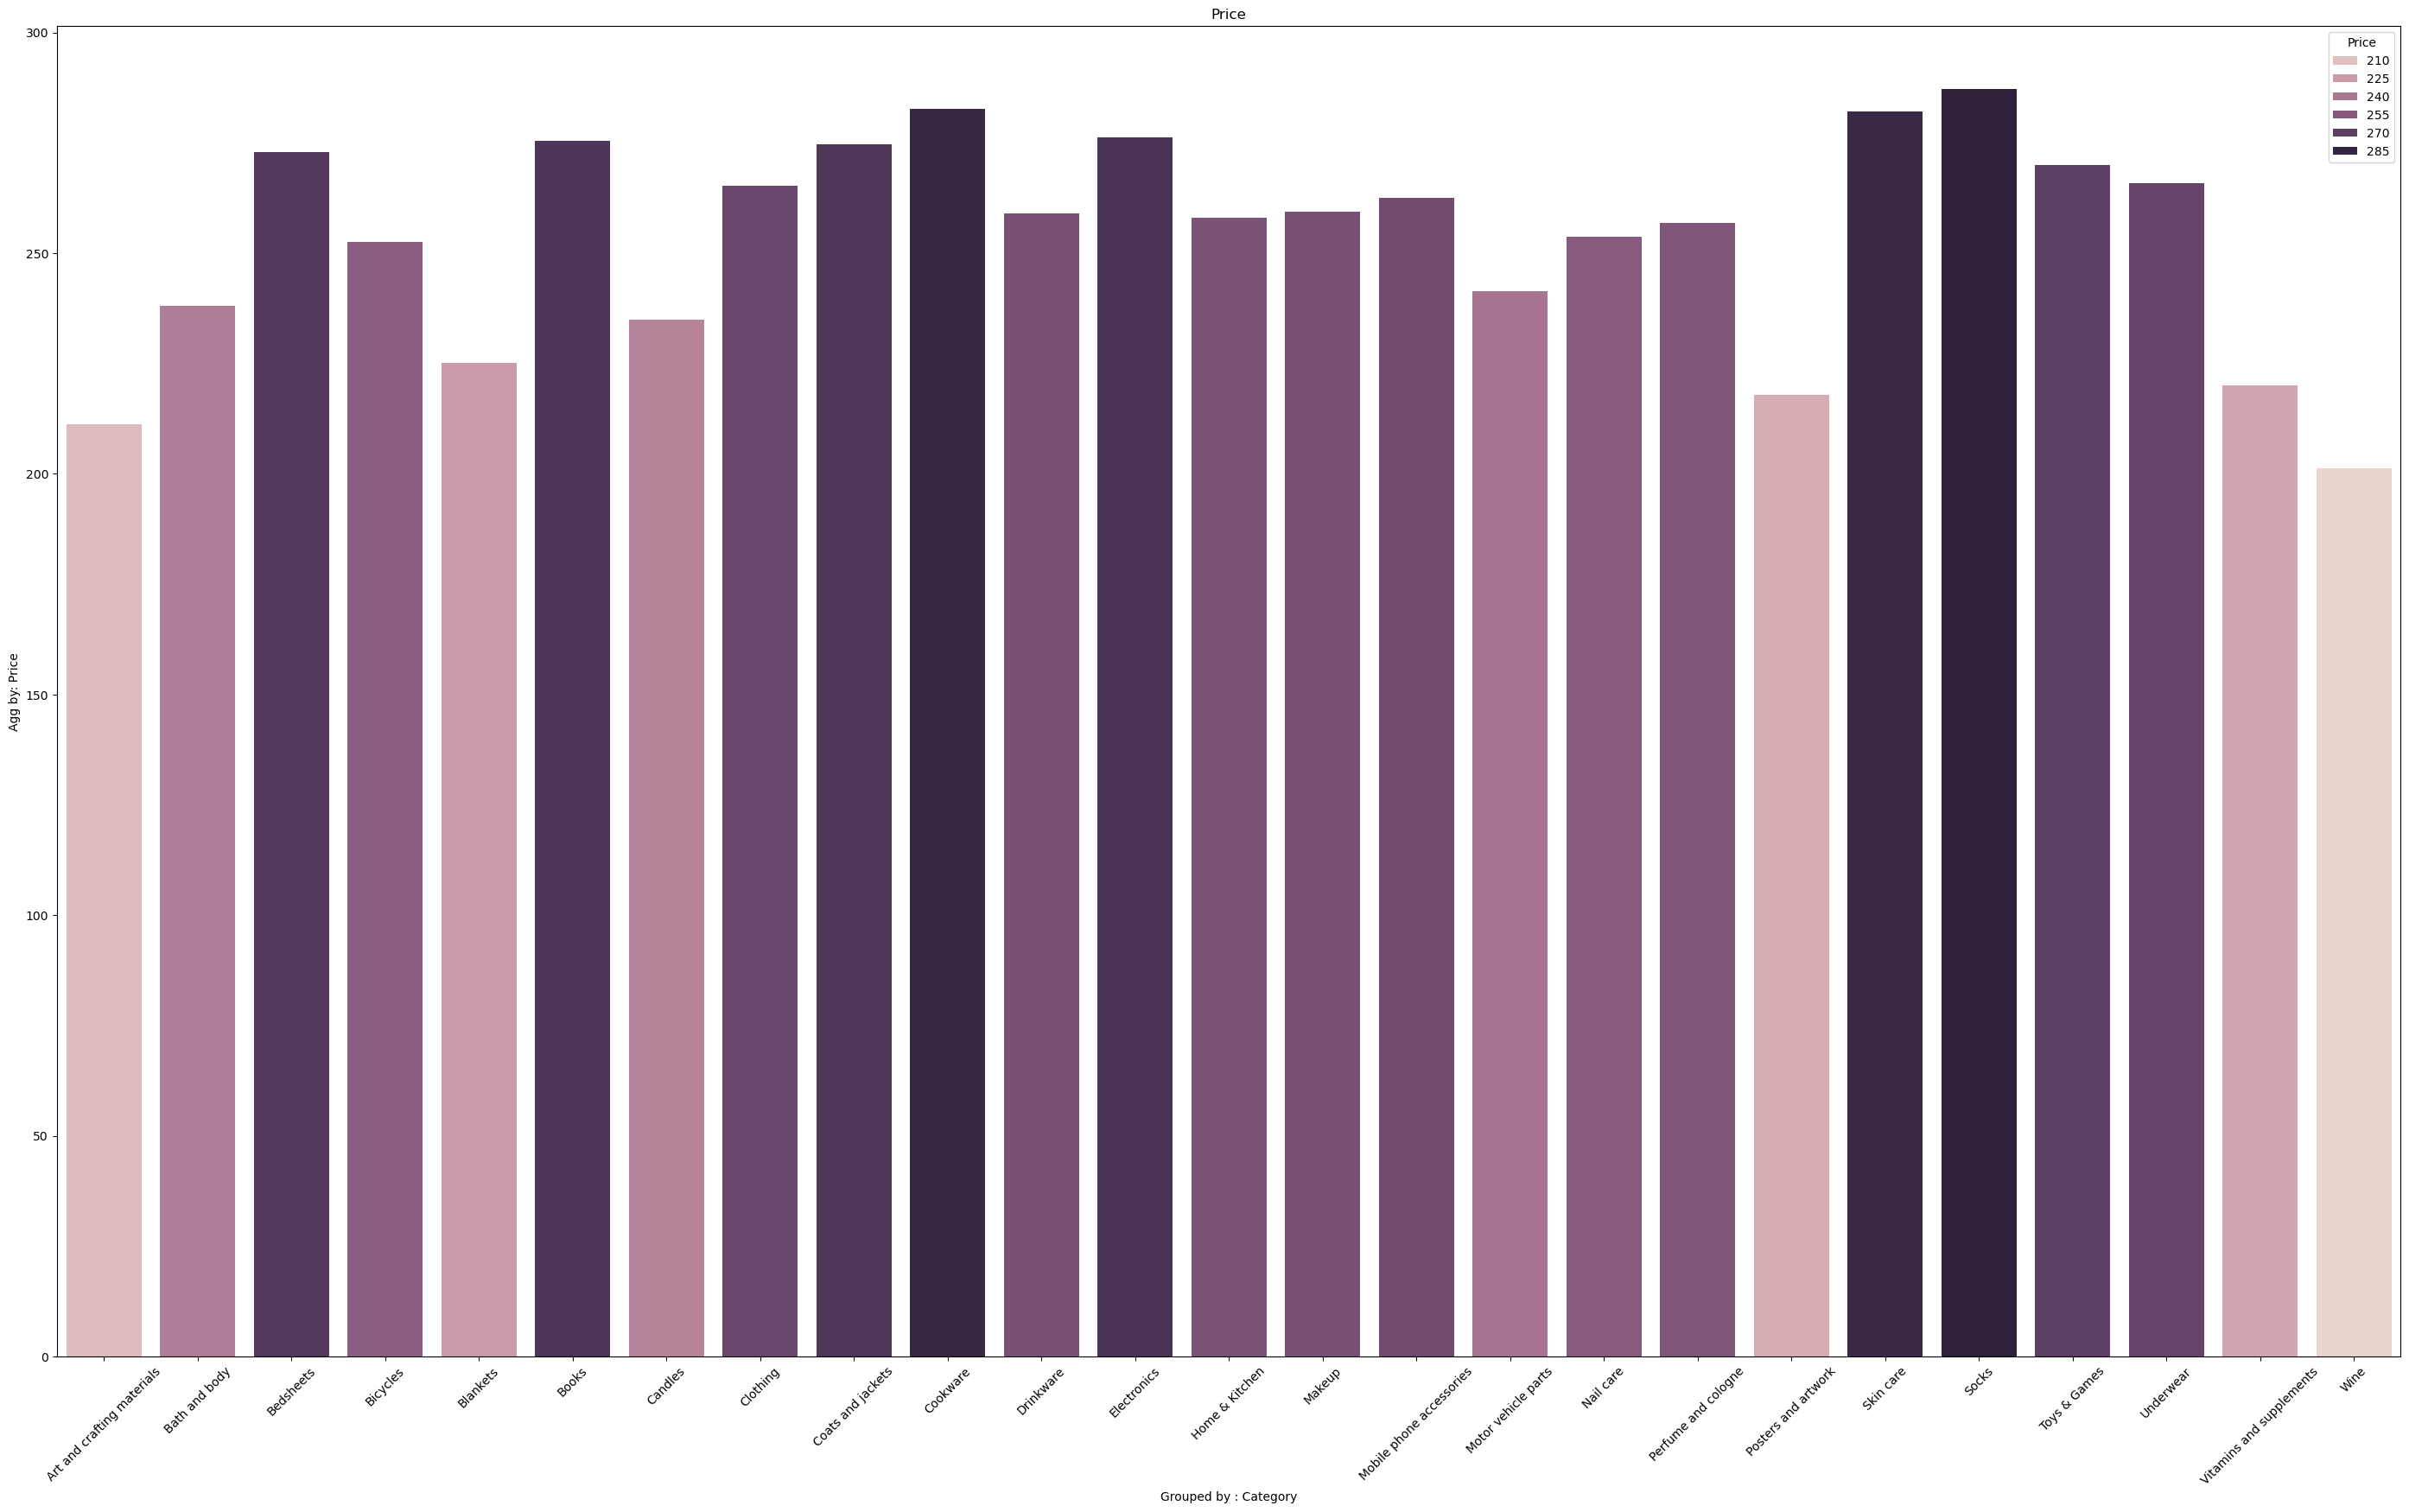

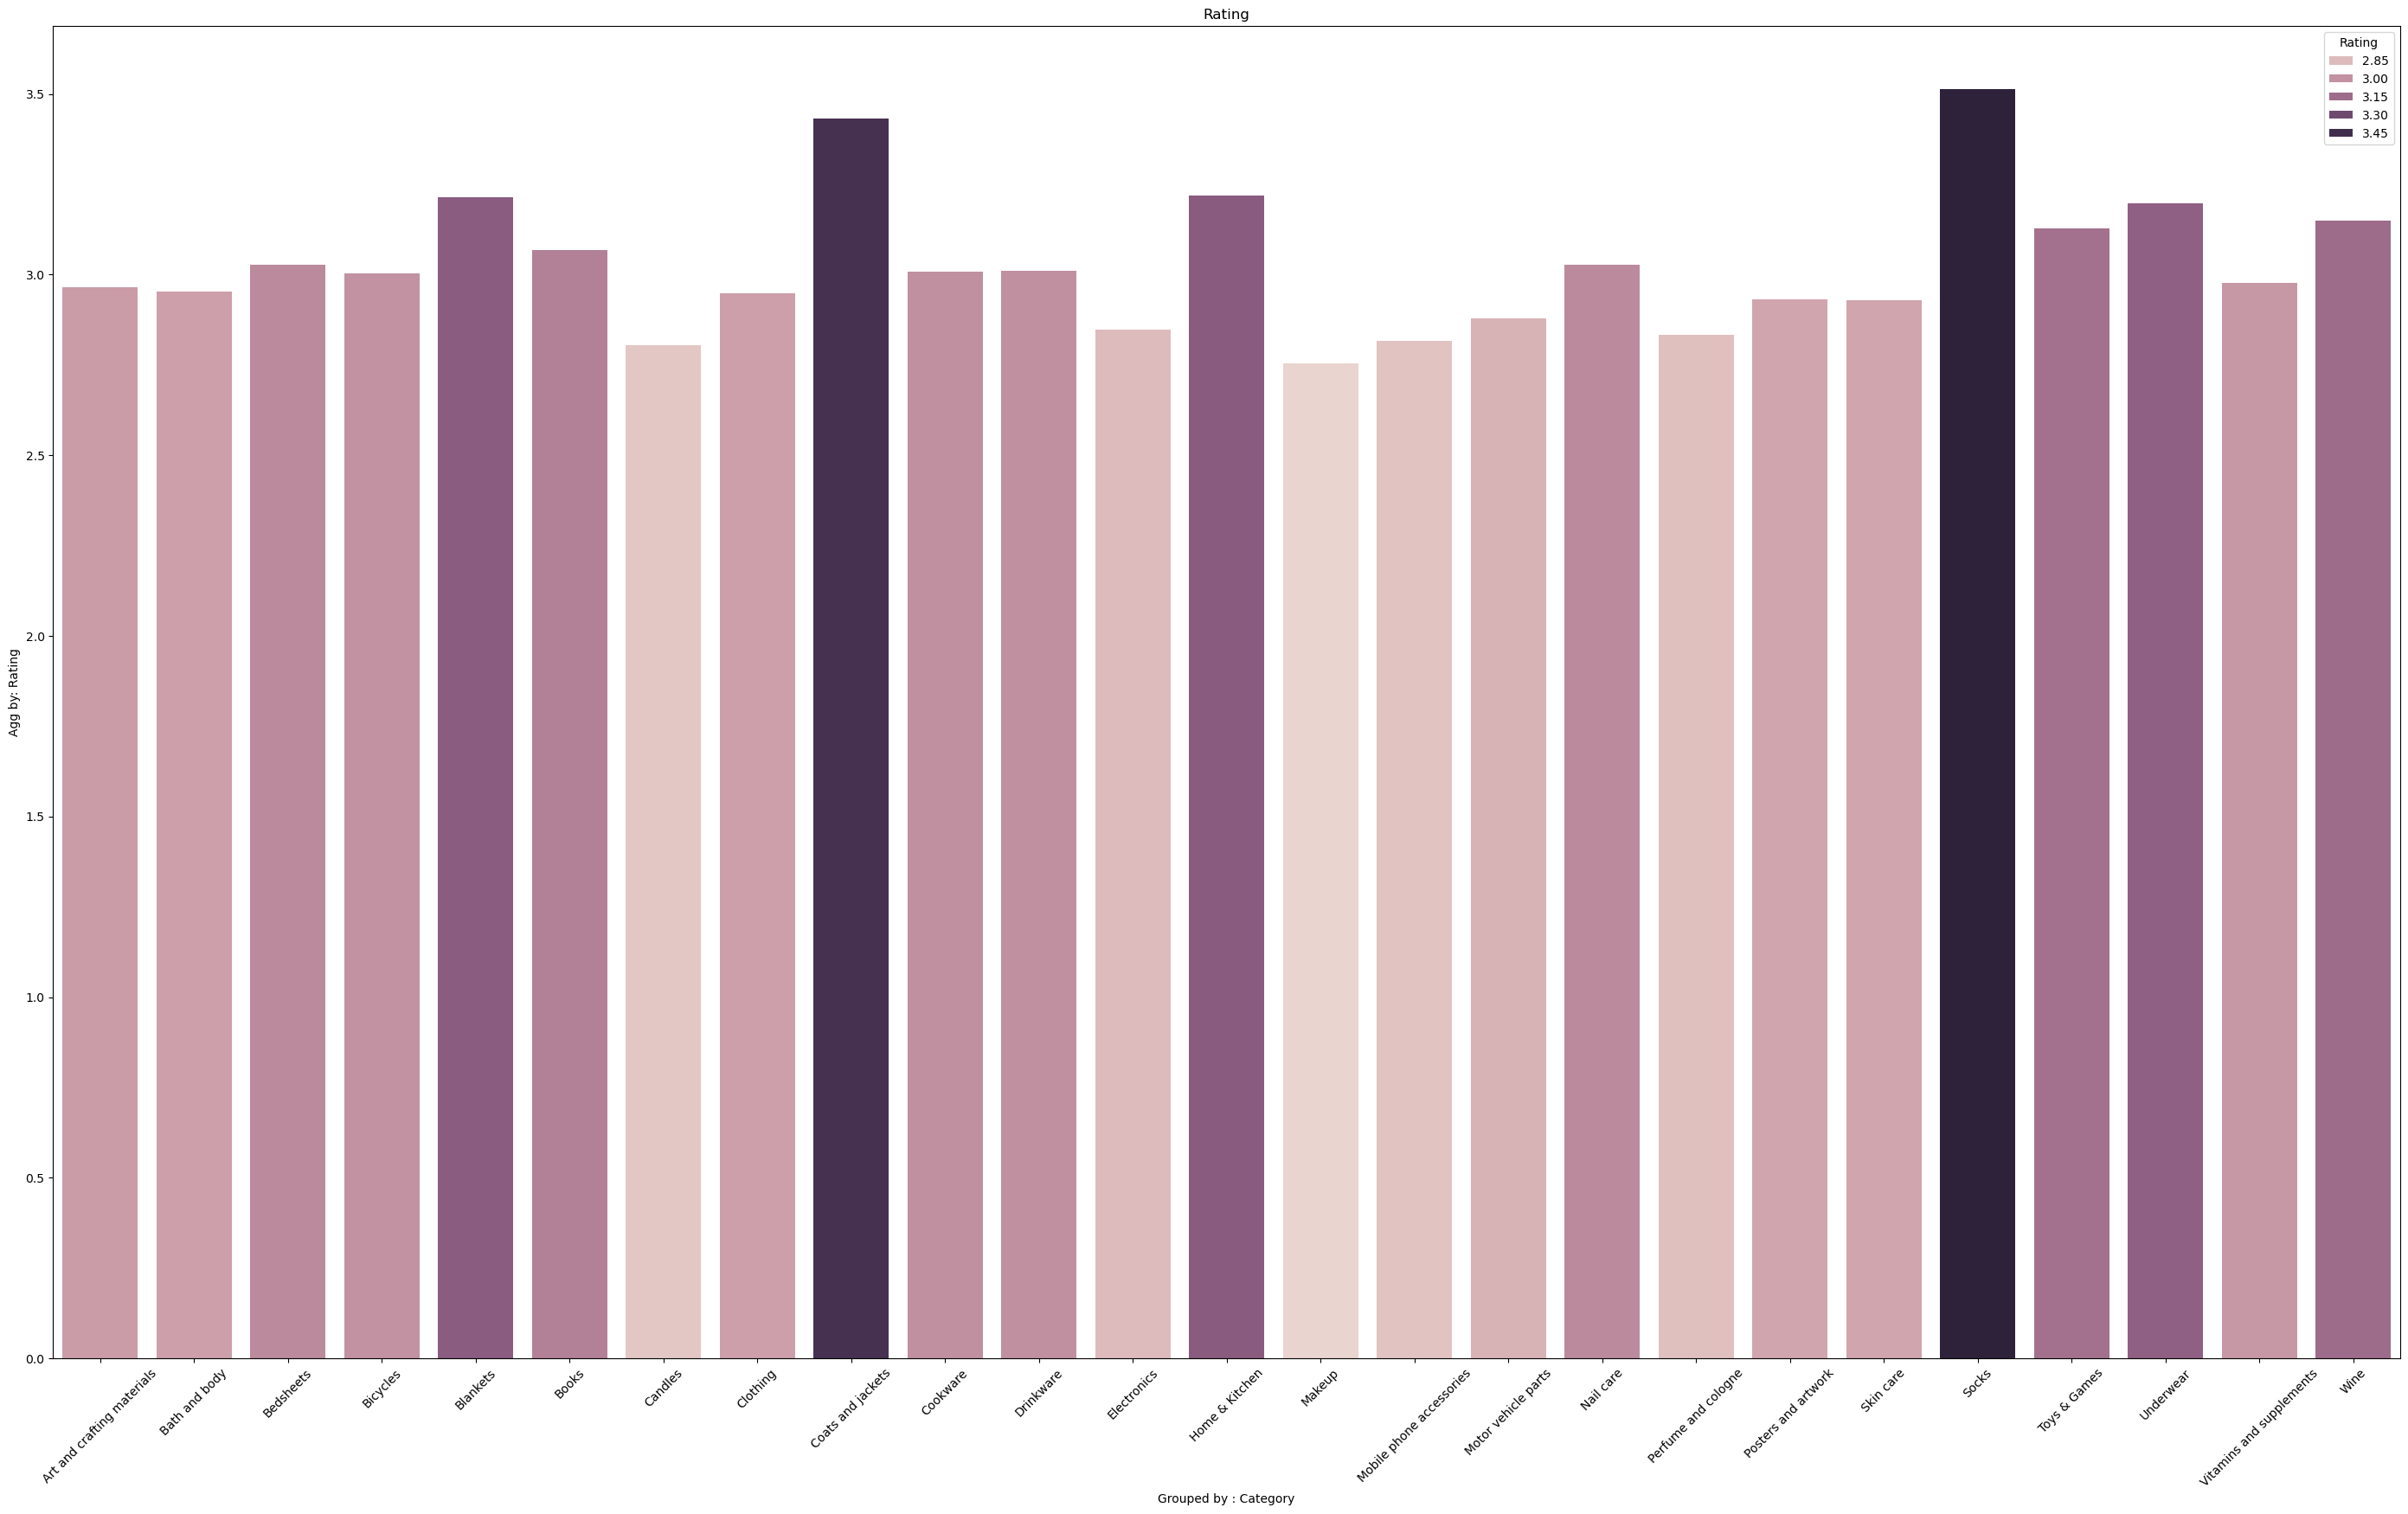

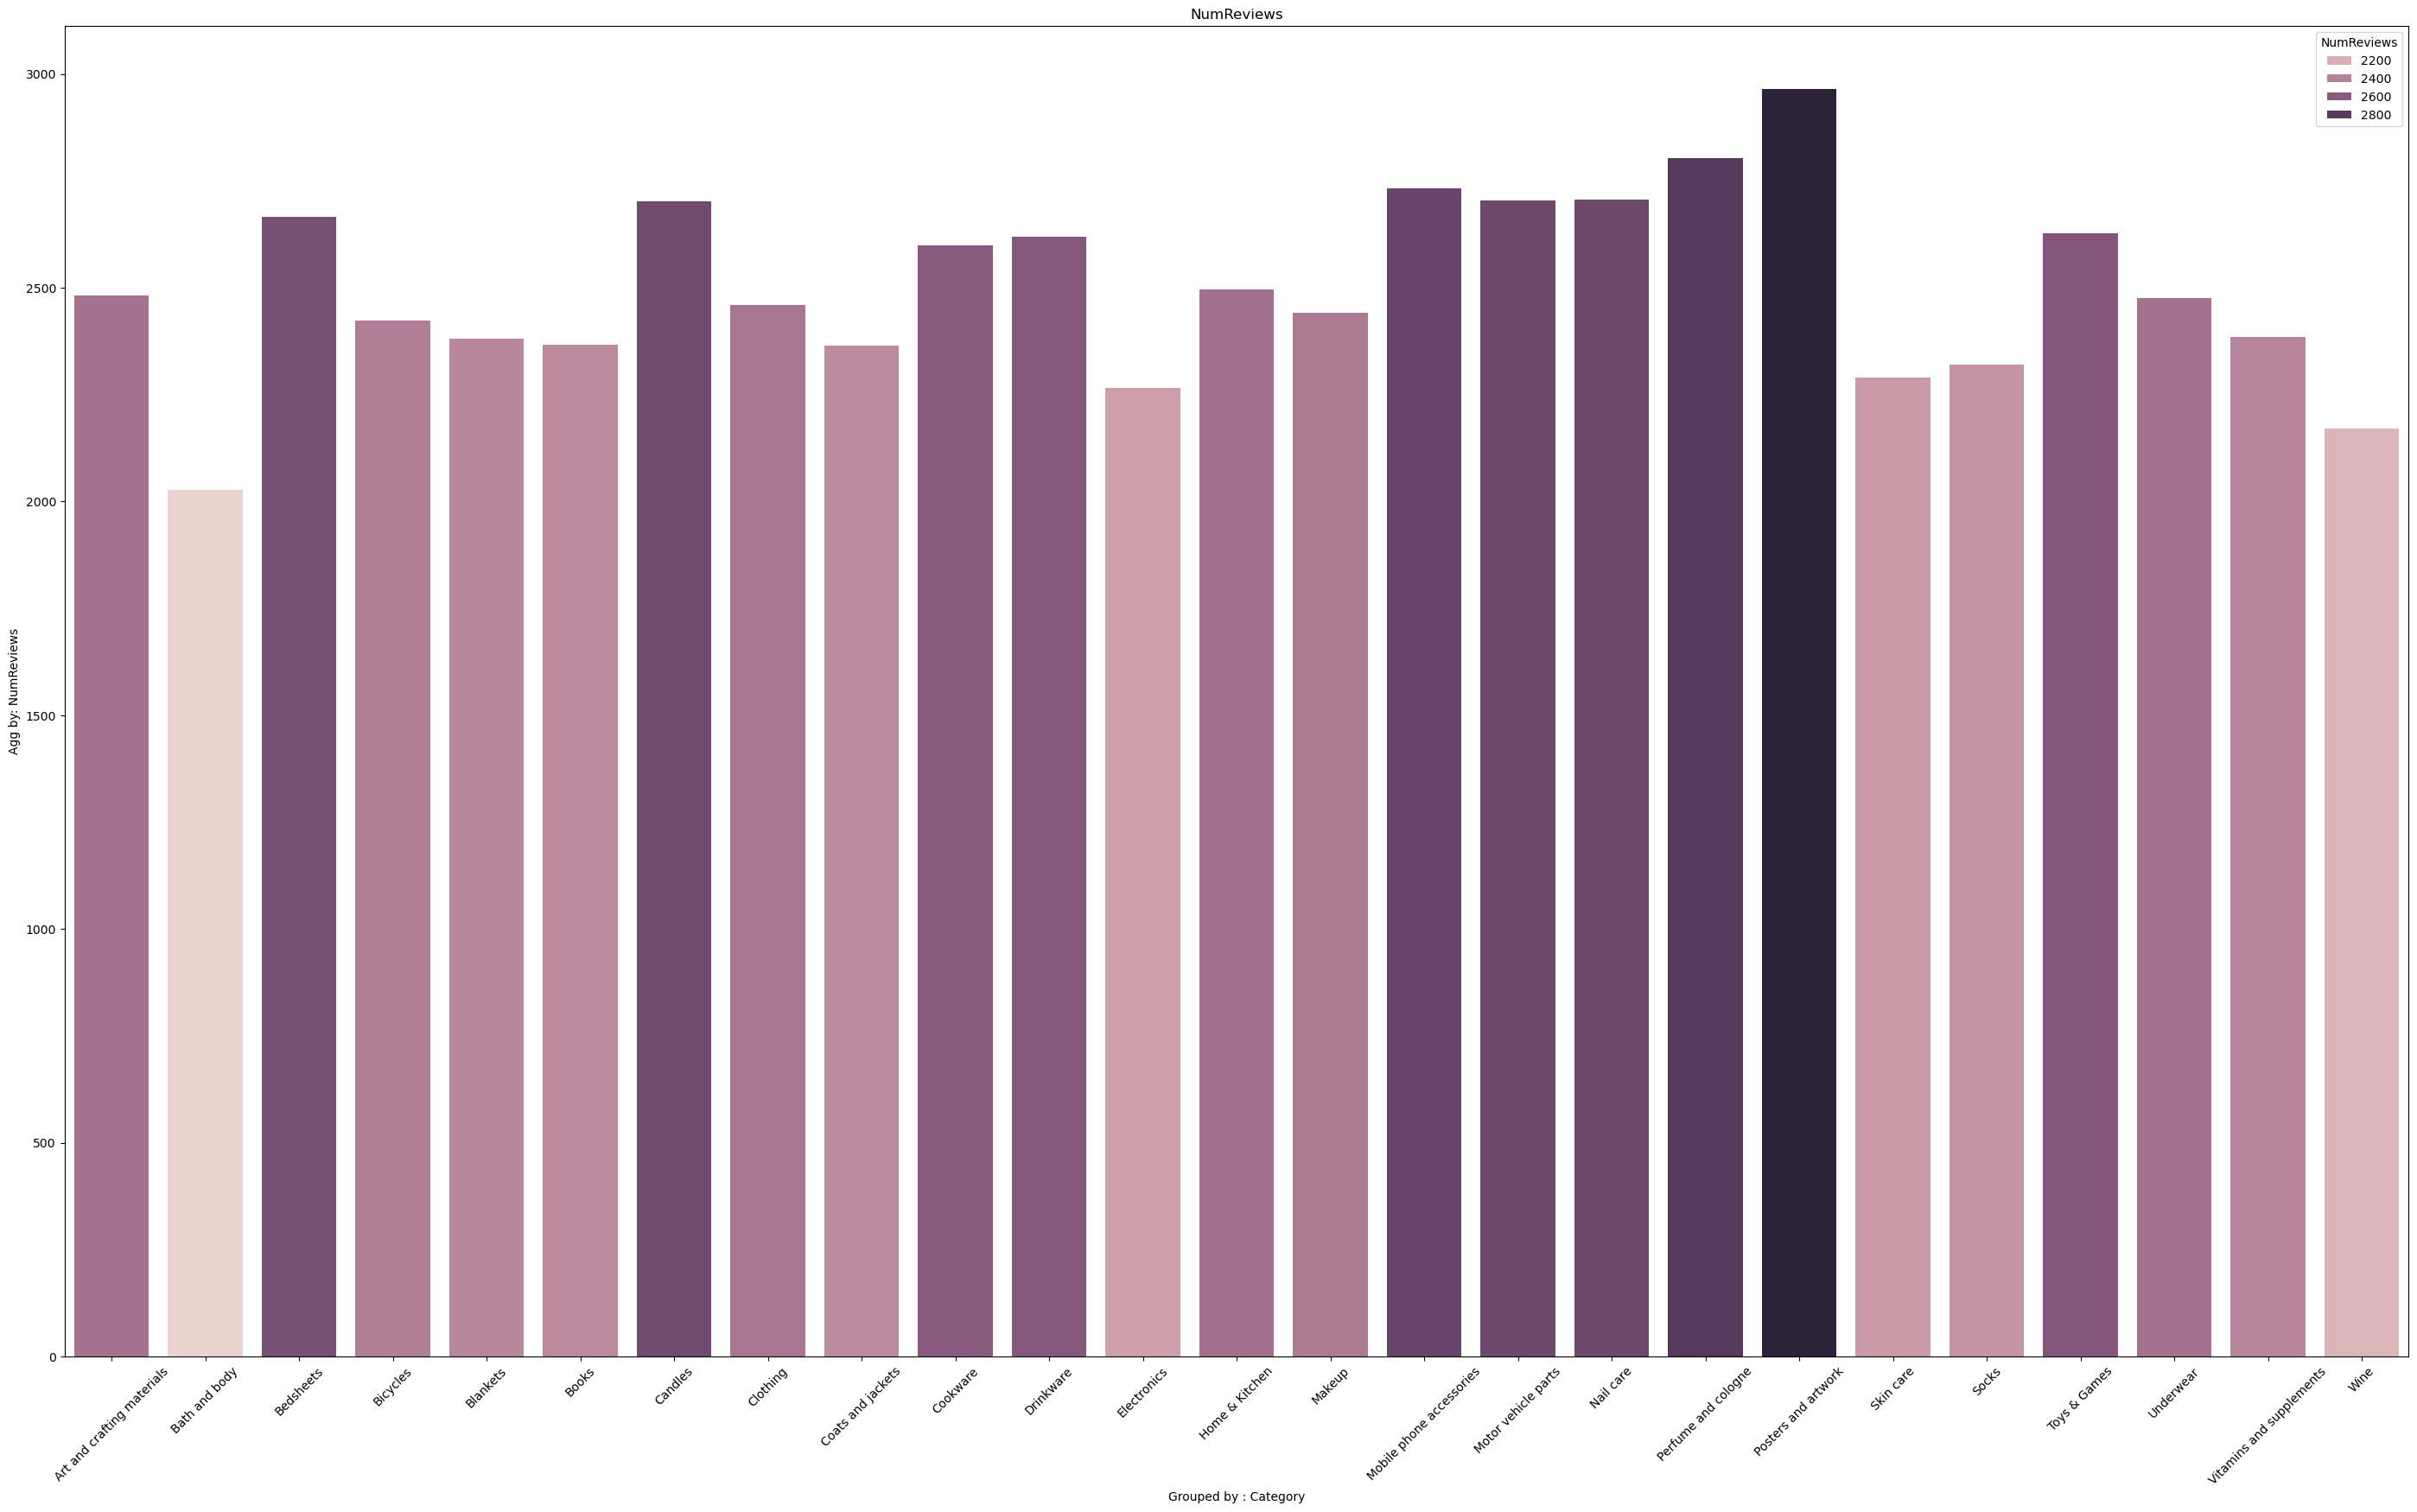

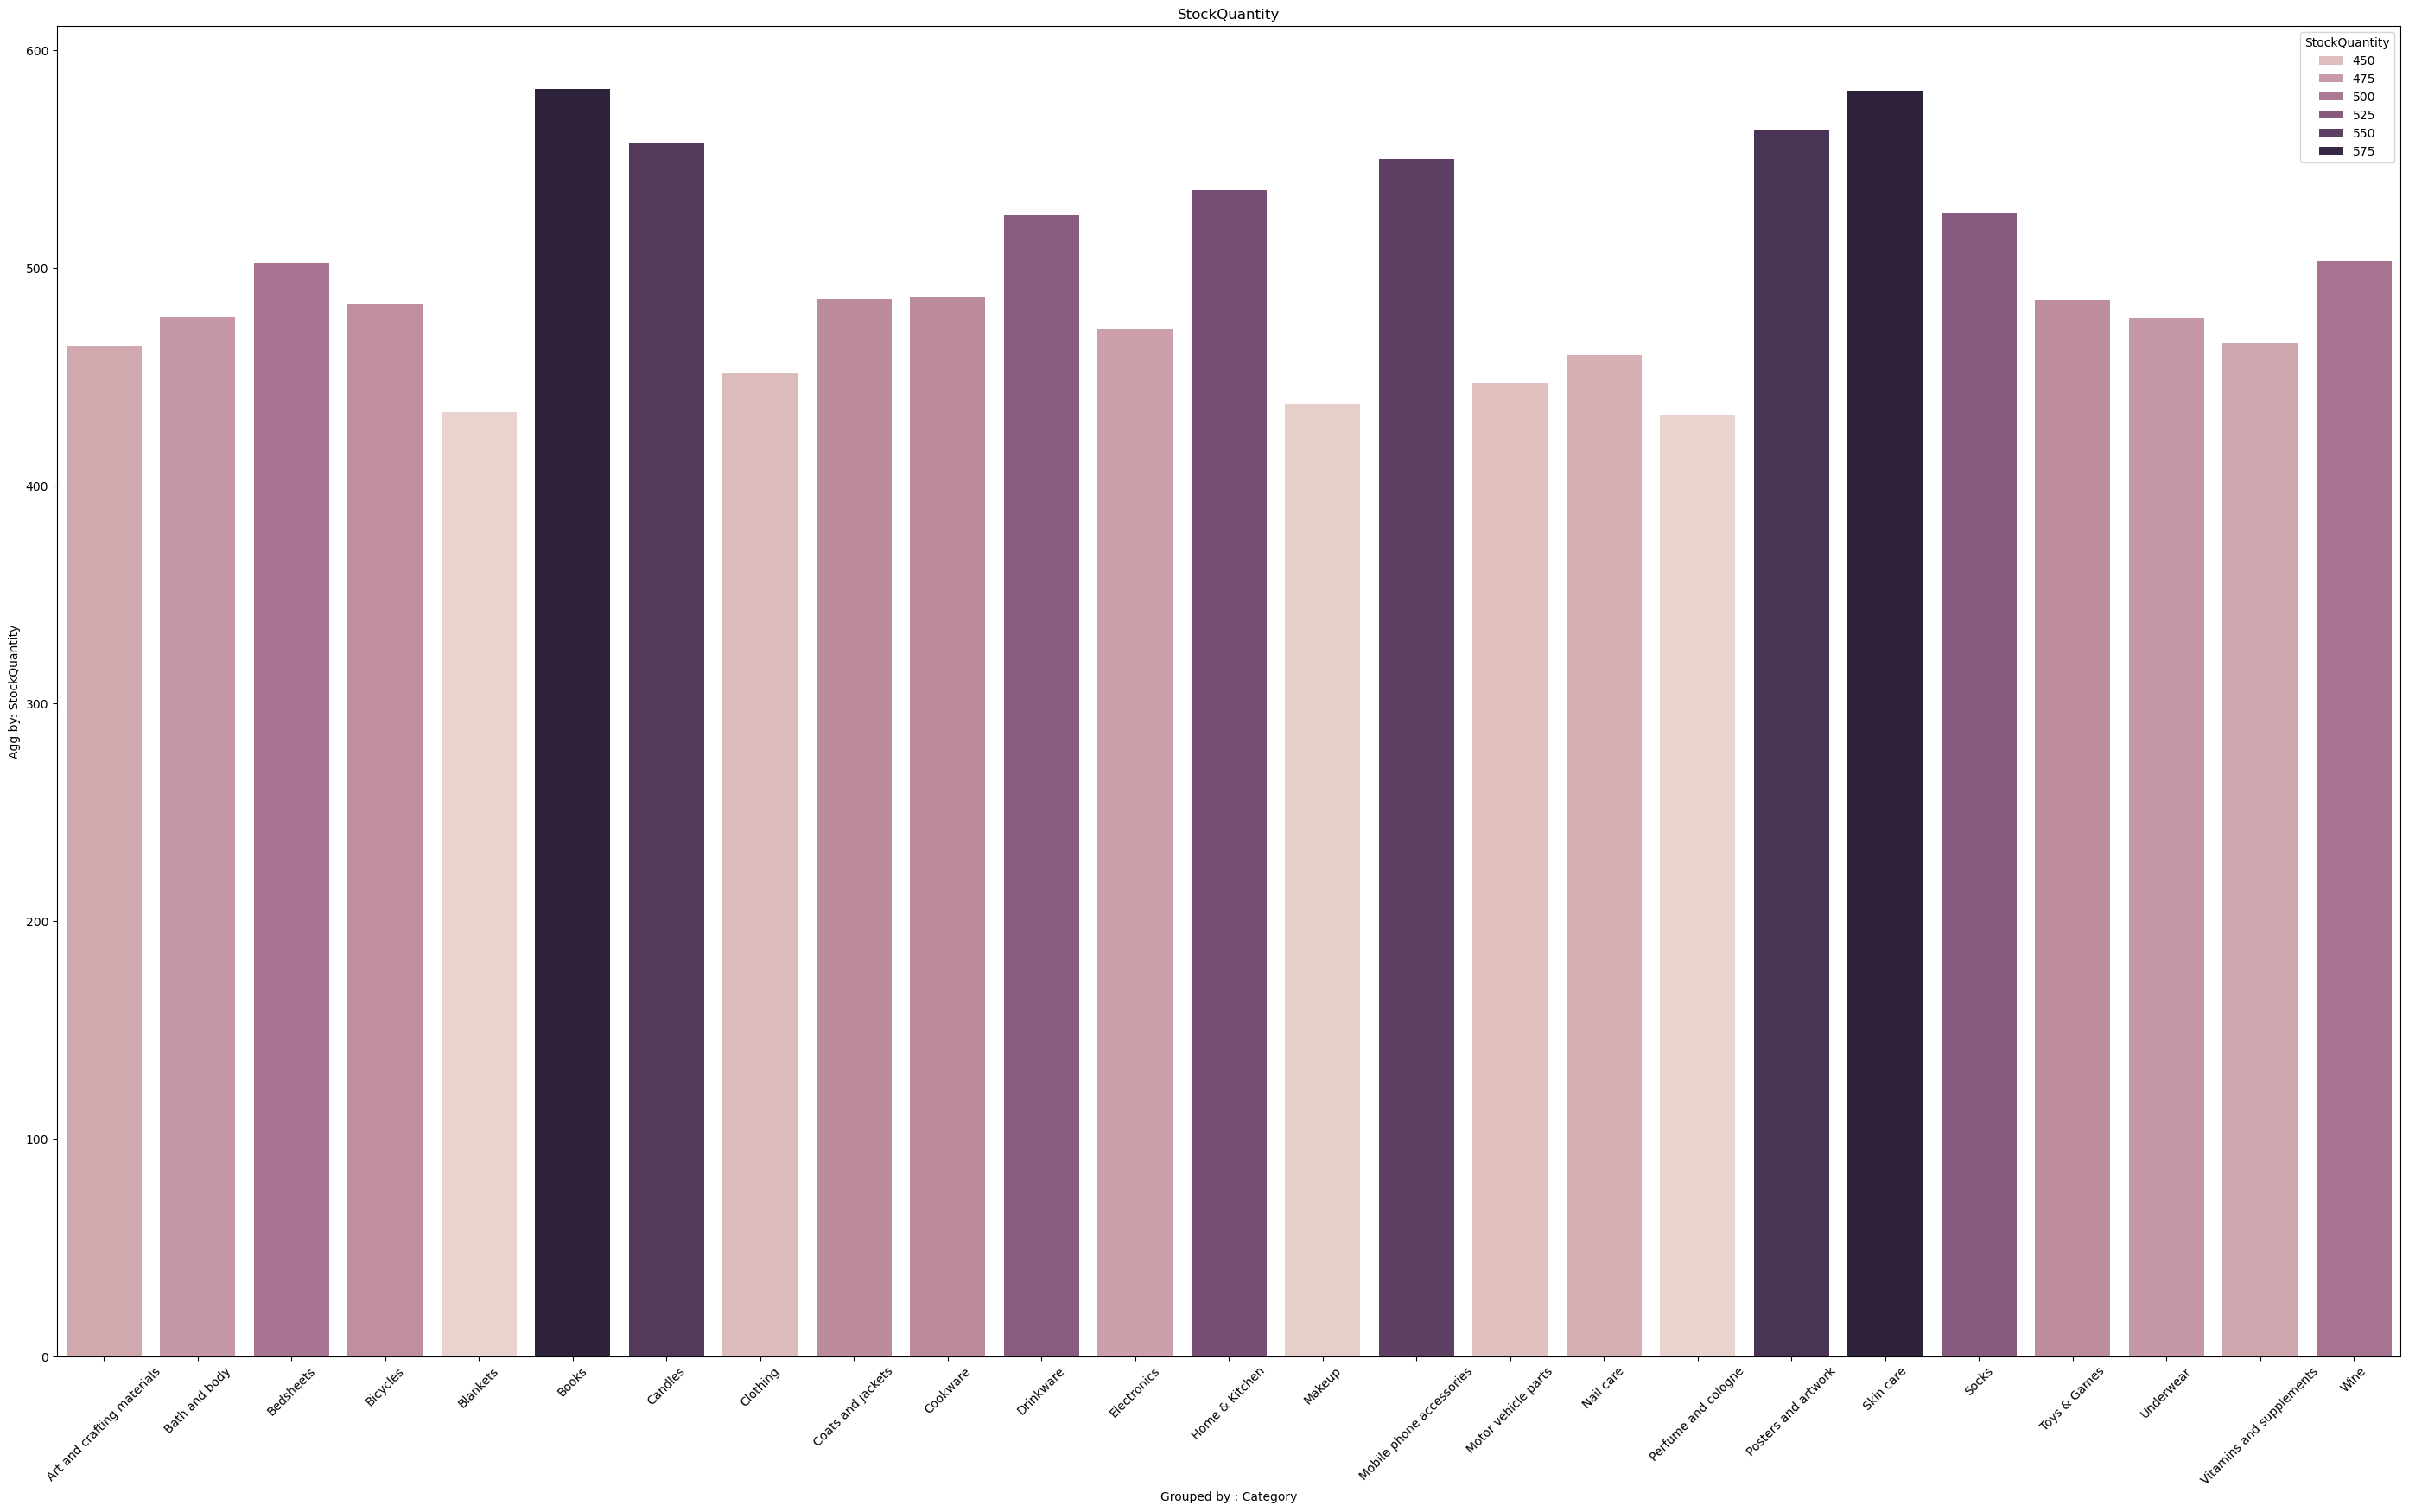

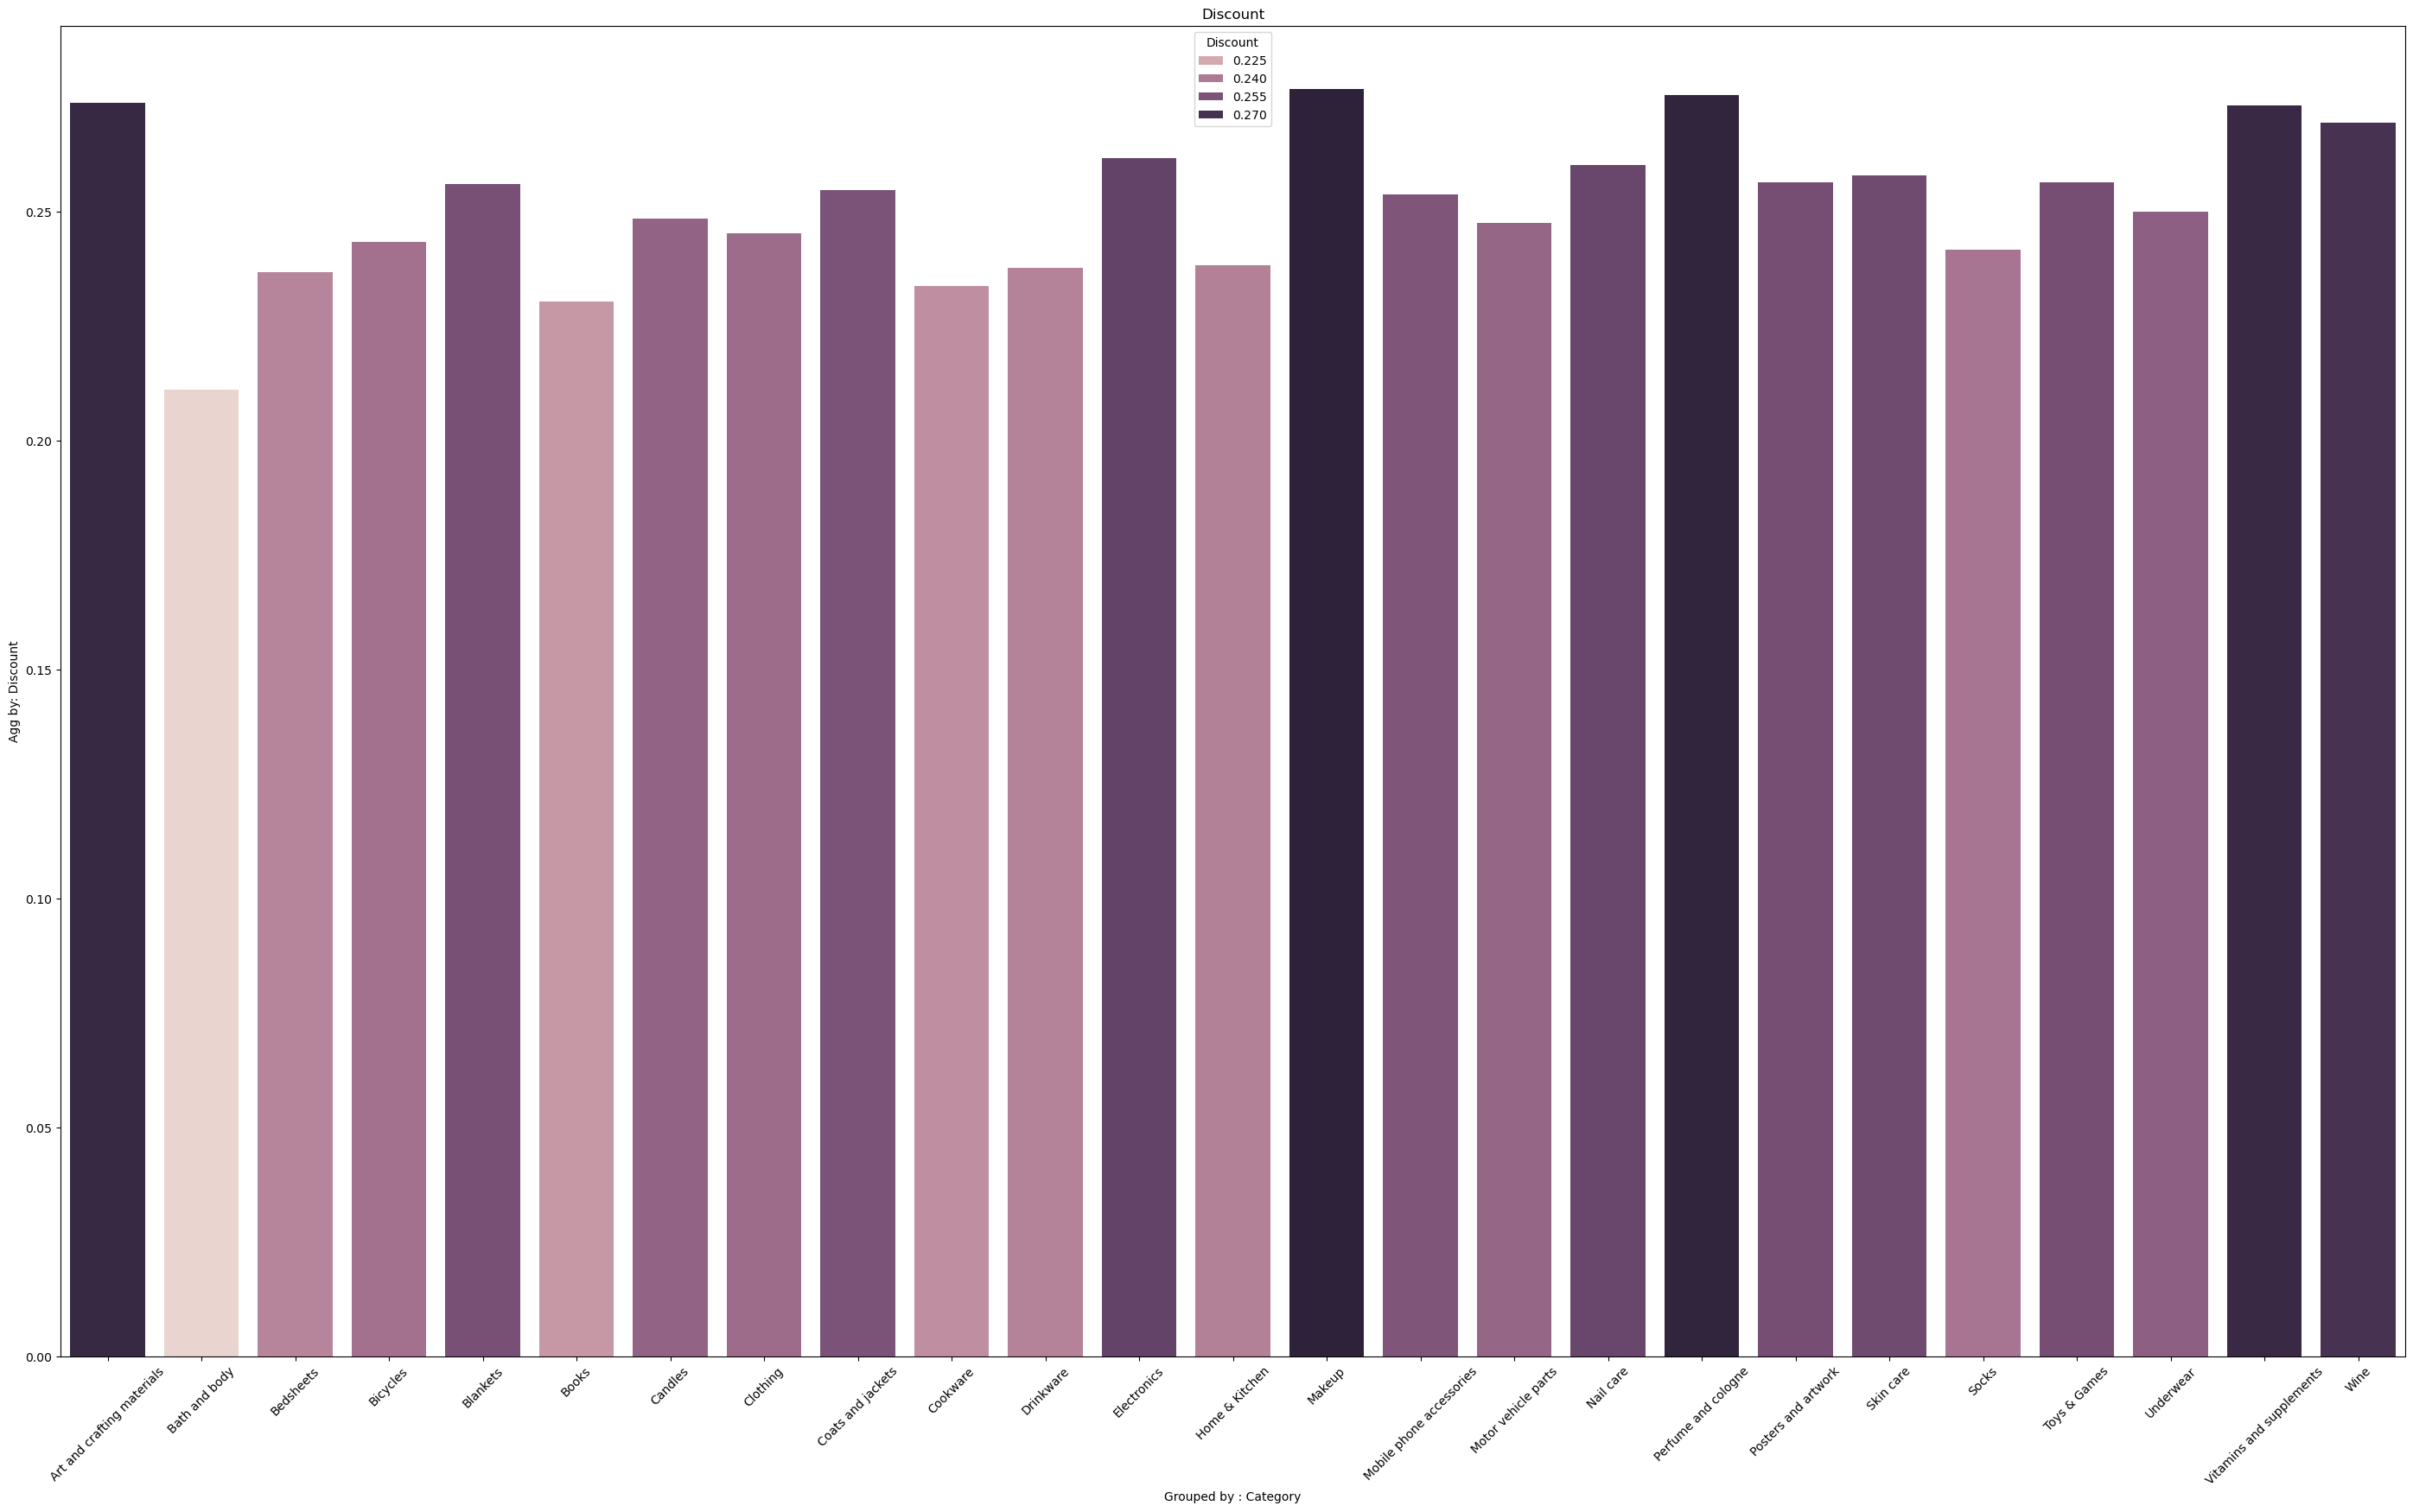

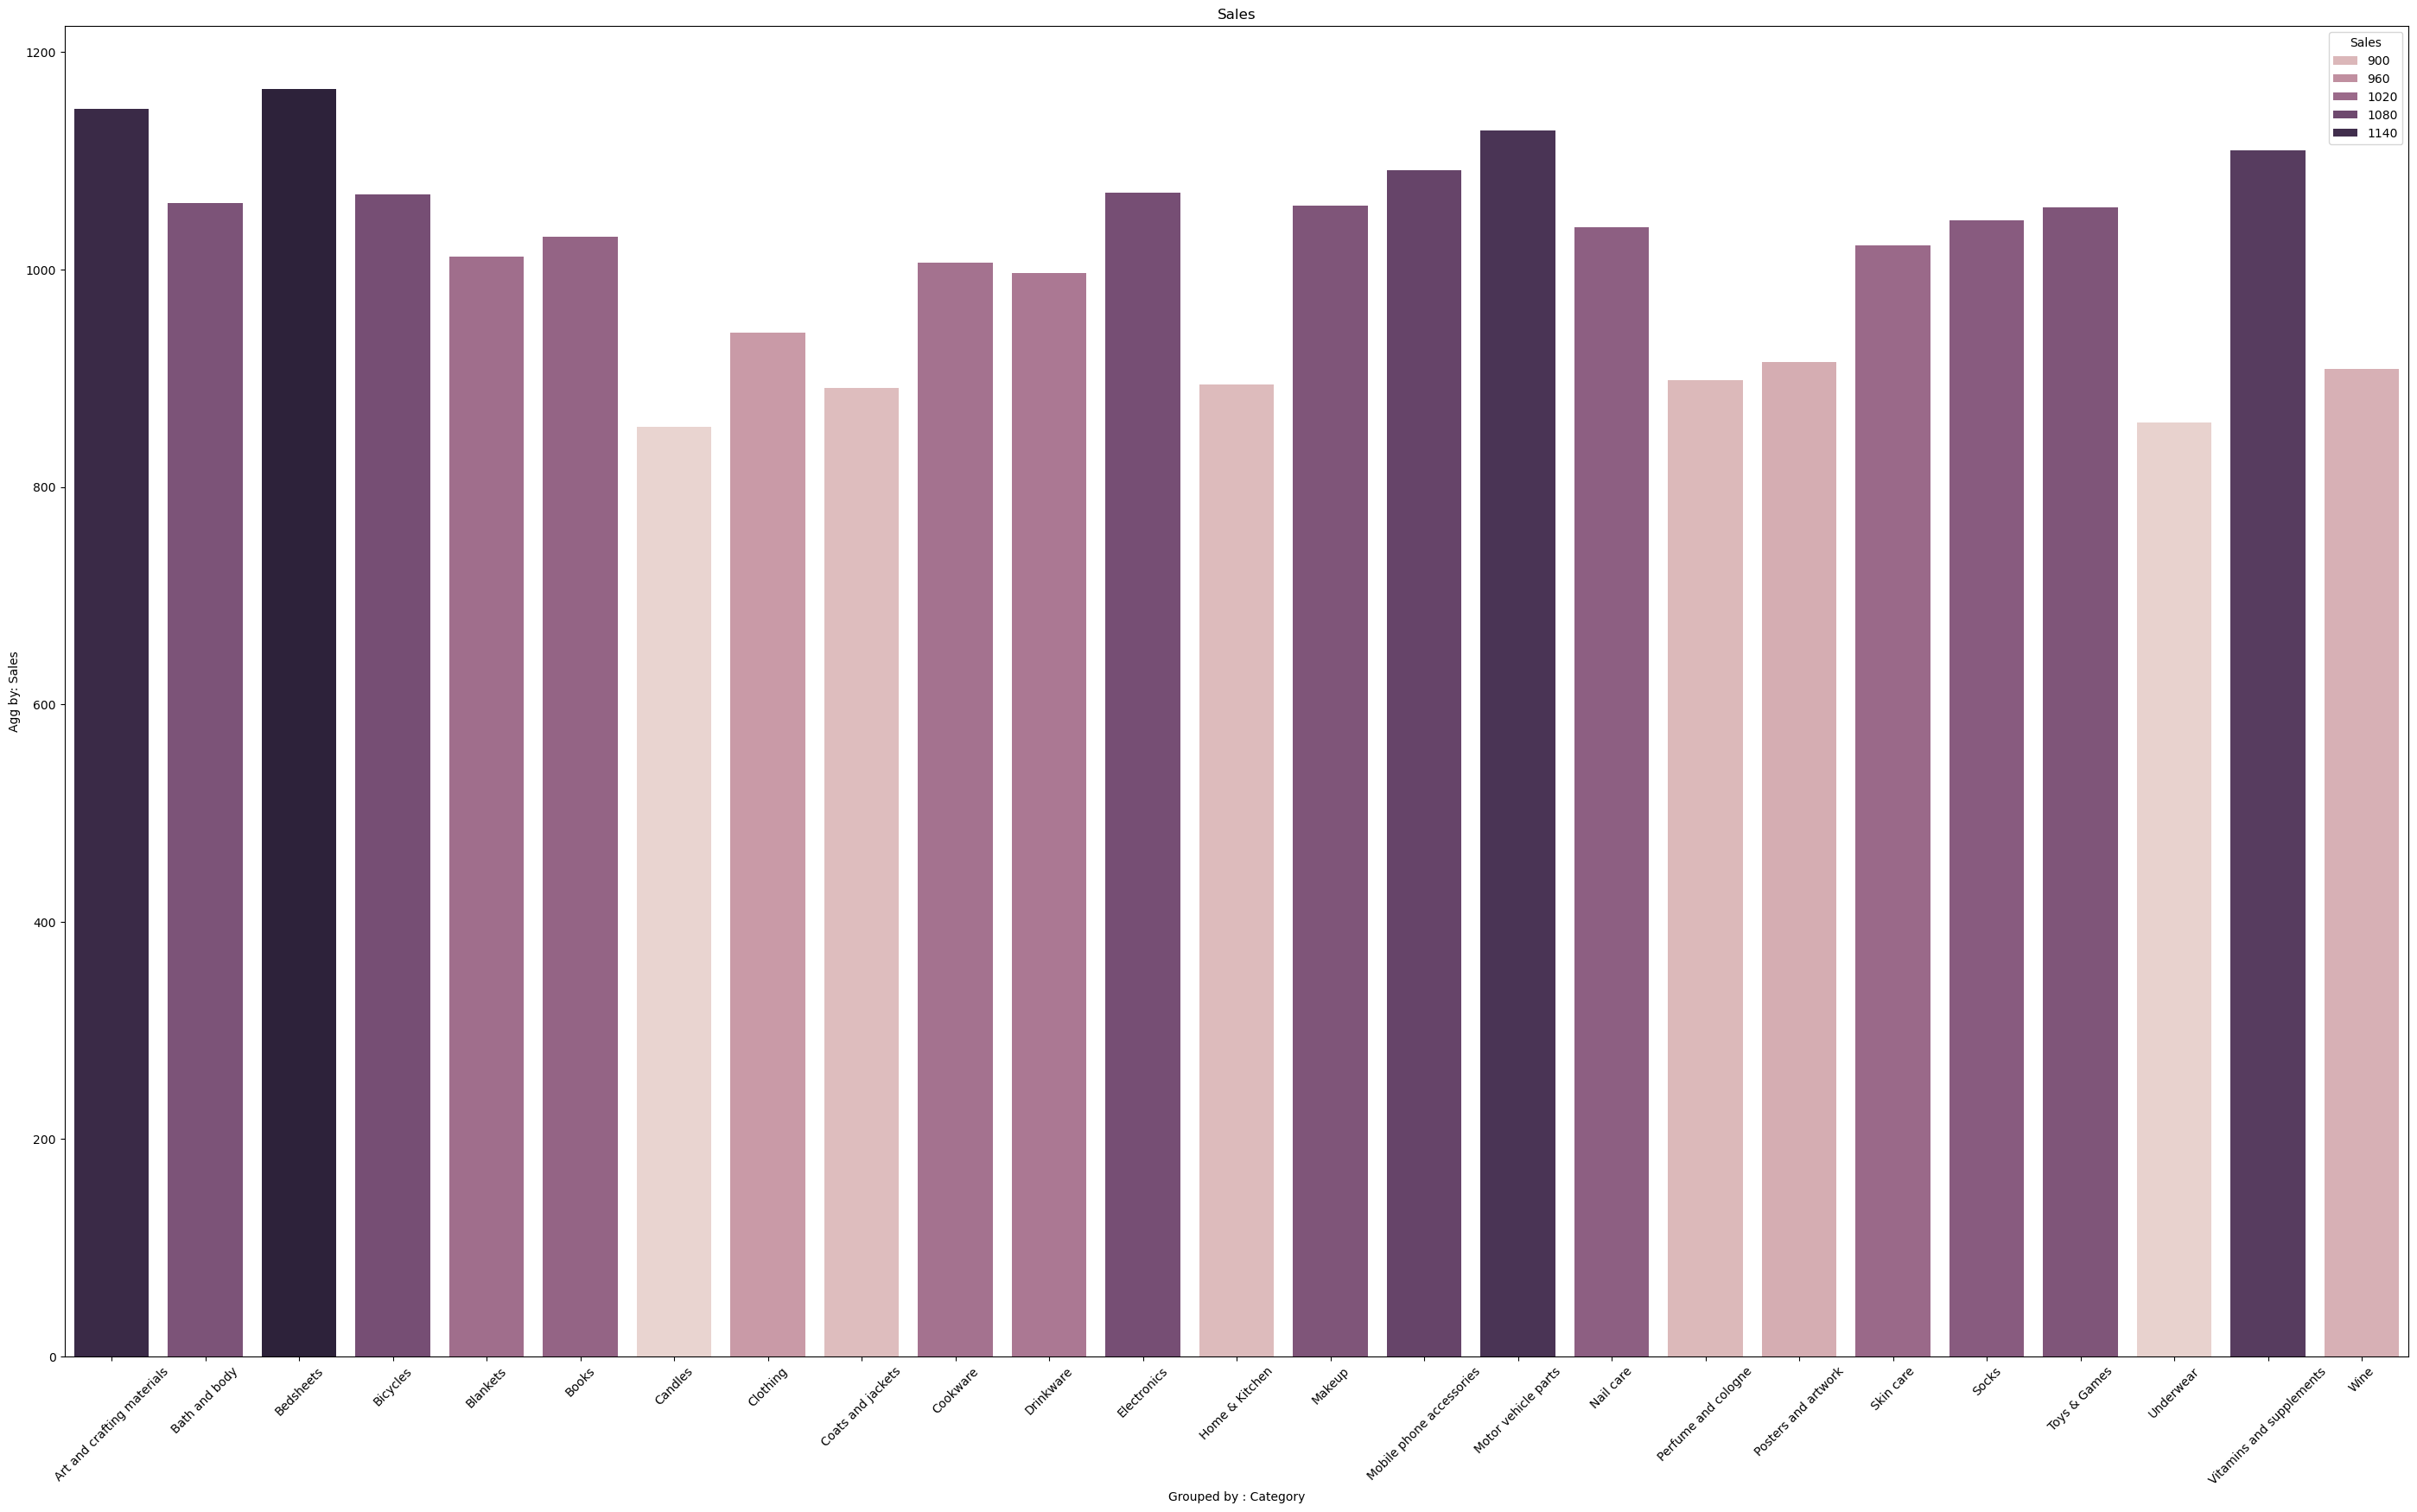

In [20]:
aggregate_views(df, "Category", "mean", interested_columns, (35, 20))

# Category has 25 categories, how should we narrows this down? Is the next step.

In [21]:
df["Category"].value_counts()

Electronics                   40
Wine                          40
Mobile phone accessories      40
Motor vehicle parts           40
Underwear                     40
Nail care                     40
Cookware                      40
Bath and body                 40
Candles                       40
Posters and artwork           40
Bedsheets                     40
Socks                         40
Perfume and cologne           40
Clothing                      40
Drinkware                     40
Art and crafting materials    40
Bicycles                      40
Coats and jackets             40
Makeup                        40
Skin care                     40
Vitamins and supplements      40
Toys & Games                  40
Books                         40
Home & Kitchen                40
Blankets                      40
Name: Category, dtype: int64

### Clothing

- Underwear
- Socks
- Clothing
- Coats and jackets

### Electronics

- Electronics 
- Mobile phone accessories
- Motor vehicle parts
- Bicycles

### Home Applicances

- Blankets  
- Home & Kitchen
- Posters and artwork 
- Candles 
- Bedsheets
- Drinkware 
- Art and crafting materials
- Books
- Toys & Games
- Cookware

### Self Care

- Nail care
- Vitamins and supplements
- Skin care 
- Perfume and cologne
- Bath and body
- Makeup
- Wine

# This is not perfect here, given that we mixed up some categories that seem forced. However, we will have to test and see the results and then revaluate our slicing methods here.

In [22]:
cat_mappings = {
  "Clothing":[
  "Underwear",
  "Socks",
  "Clothing",
  "Coats and jackets"
],
  "Electronics":[
  "Electronics",
  "Mobile phone accessories",
  "Motor vehicle parts",
  "Bicycles"
  ],
  
  "Electronics":[
  "Electronics",
  "Mobile phone accessories",
  "Motor vehicle parts",
  "Bicycles"
  ],
  
  "Home Applicances":[
  "Blankets",
  "Home & Kitchen",
  "Posters and artwork",
  "Candles",
  "Bedsheets",
  "Drinkware",
  "Art and crafting materials",
  "Books",
  "Toys & Games",
  "Cookware"
  ],
  
  "Self Care":[
  "Nail care",
  "Vitamins and supplements",
  "Skin care",
  "Perfume and cologne",
  "Bath and body",
  "Makeup",
  "Wine"
  ]
  }

# Mapping Function

In [23]:
def map_category_to_product(product, cat_mappings):
  
  for key, values in cat_mappings.items():
    if product in values:
      return key
    
df["Category"] = df["Category"].apply(lambda product: map_category_to_product(product, cat_mappings))

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Home Applicances'),
  Text(1, 0, 'Self Care'),
  Text(2, 0, 'Electronics'),
  Text(3, 0, 'Clothing')])

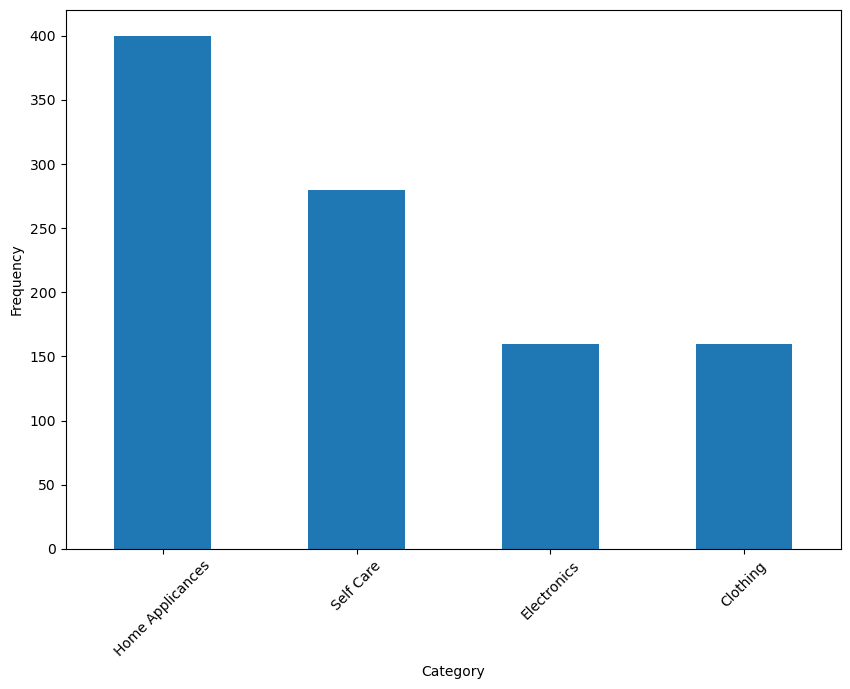

In [24]:
plt.figure(figsize=(10, 7))
df["Category"].value_counts().plot.bar(xlabel="Category", ylabel="Frequency")
plt.xticks(rotation=45)

# Check Imbalance

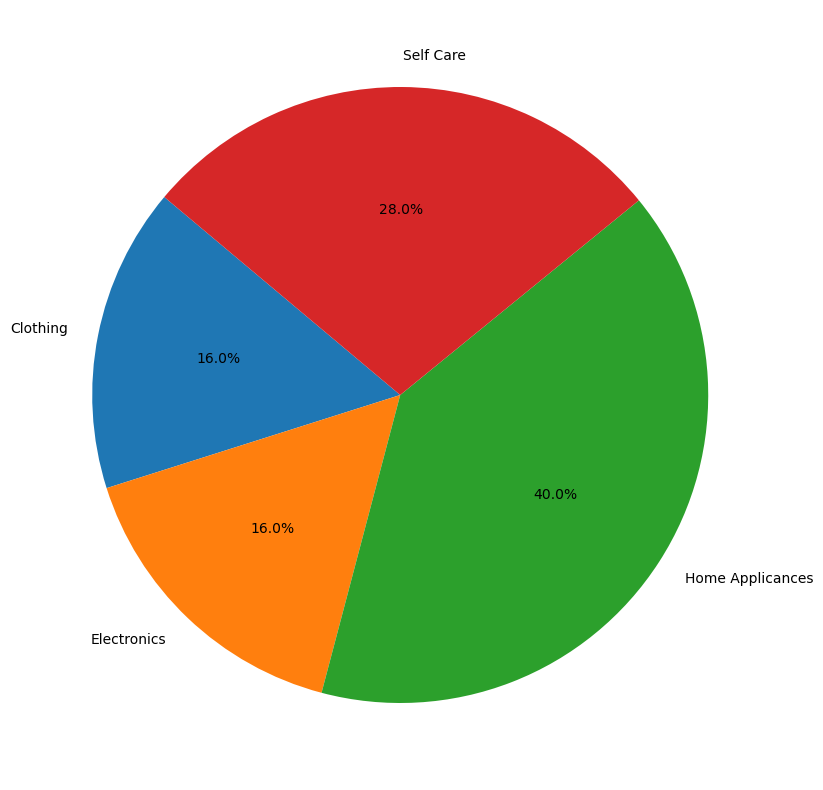

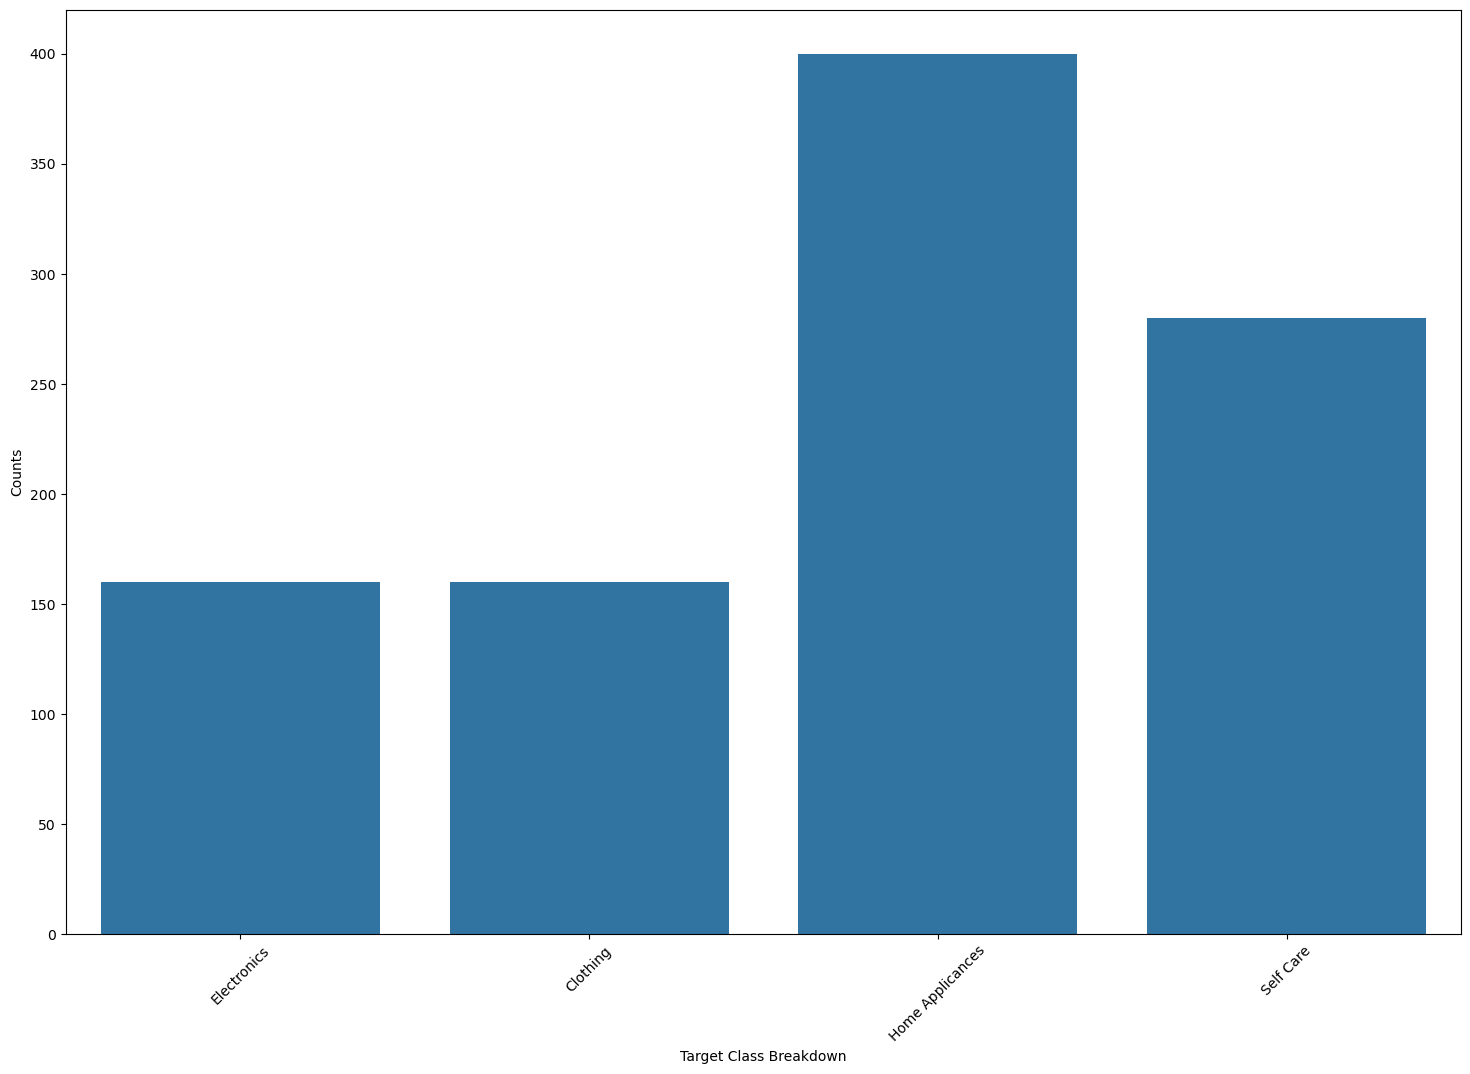

In [43]:
check_class_imbalance(df["Category"])

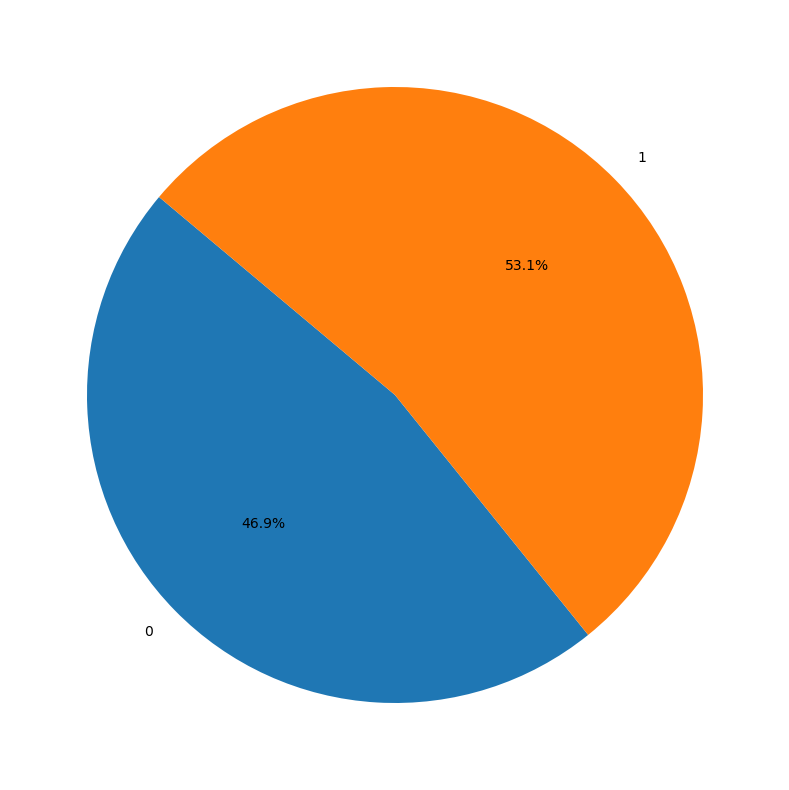

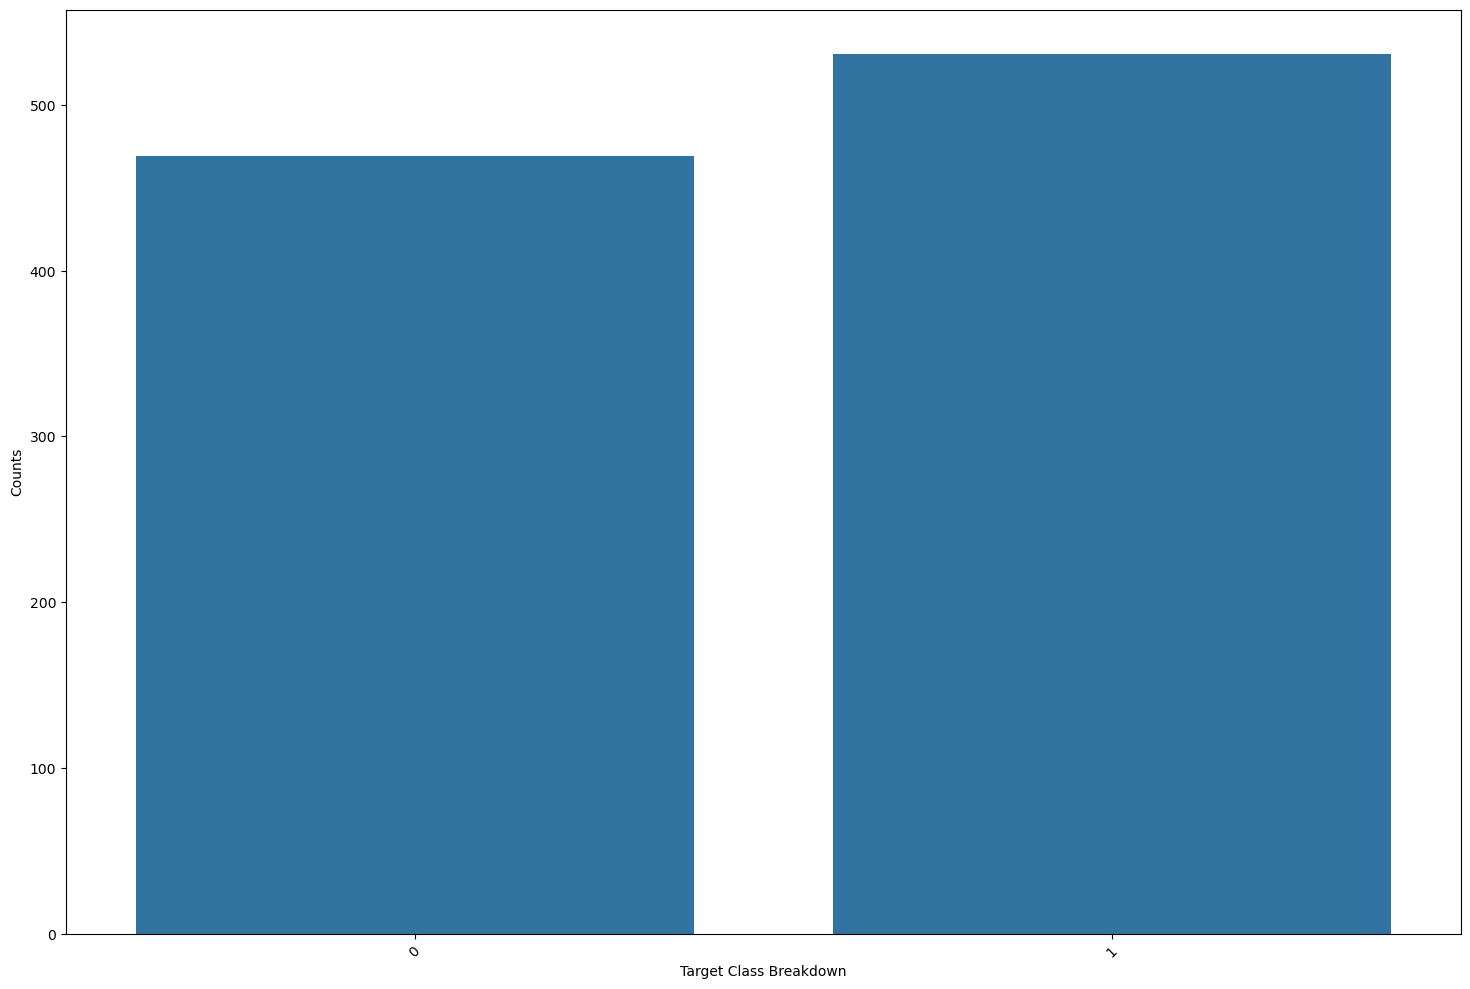

In [44]:
check_class_imbalance(df["Rating"])

# So now we must decide our business objective and define this as a ML problem, we could do the following:

- If our goal is to understand what drives sales, then Sales could be a good target variable. You would use other variables like Price, StockQuantity, and Discount as predictors.

- If we're interested in understanding consumer behavior, such as what influences a product’s rating, then Rating might be the target, using features like NumReviews, Discount, and Price.

- For a classification task, such as predicting which category a product falls into based on its characteristics, Category would be the target.

# Rating seems like the most fun predictor variable to pick so lets go with that.

<AxesSubplot:>

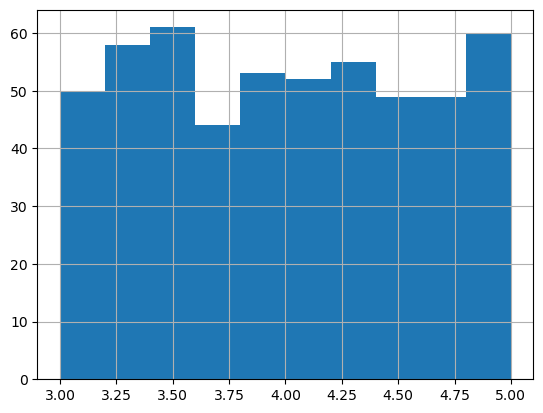

In [25]:
df[df["Rating"] >= 3.0]["Rating"].hist()

<AxesSubplot:>

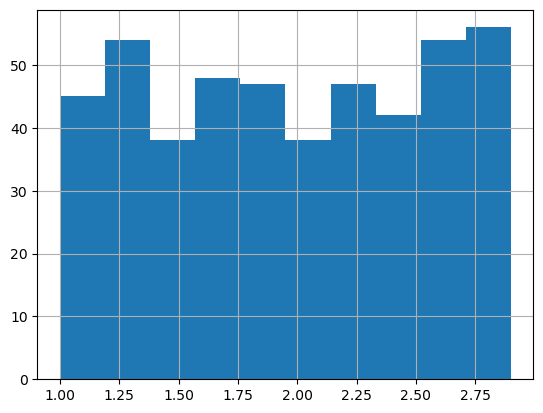

In [26]:
df[df["Rating"] < 3.0]["Rating"].hist()

In [27]:
df["Rating"] = df["Rating"].apply(lambda x: 0 if x < 3.0 else 1 if x>=3.0 and x <4.0 else 2)

In [28]:
numeric_features.drop("Rating", axis=1, inplace=True)

# Create Preprocessor

In [32]:
preprocessor = create_preprocessor(numeric_features, categorical_features)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('Scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Price', 'NumReviews', 'StockQuantity', 'Discount', 'Sales', 'year',
       'day', 'month'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Category'], dtype='object'))])

# Separate Feature Variables

In [40]:
X, y = df.drop("Rating", axis=1), df["Rating"]

# Create Metrics

In [42]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)

# Create Baseline Model

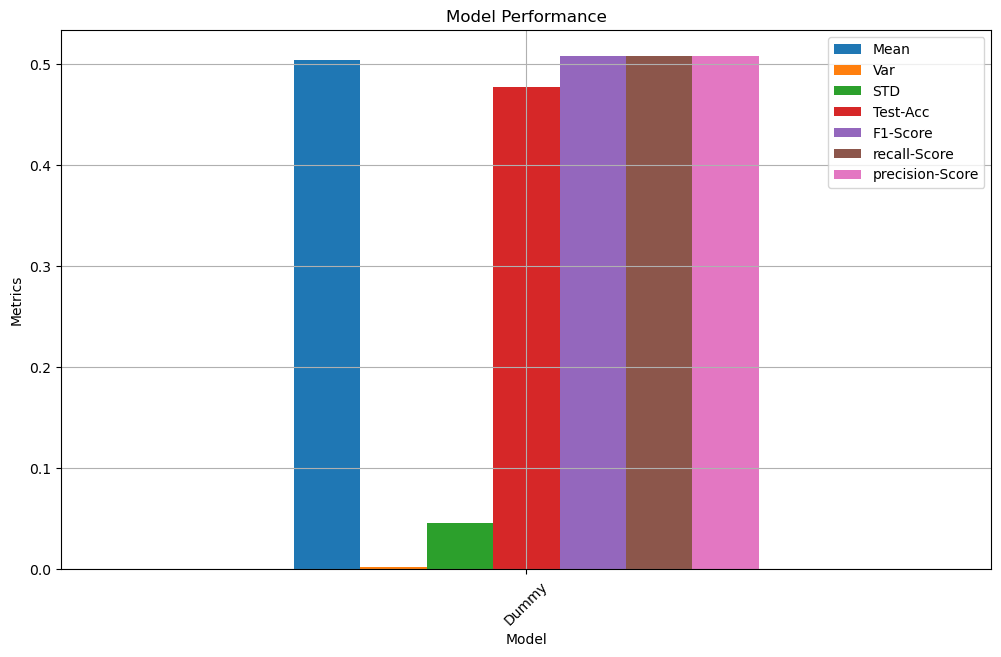

   index  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy  0.504  0.002  0.046     0.477     0.508         0.508   

   precision-Score  
0            0.508  


In [55]:
model = [DummyClassifier(strategy="uniform")]
model_names = ["Dummy"]
test_selected_models(preprocessor, model_names, model, acc_metric, X, y)

# Advanced Model Metrics

# Acc Metric

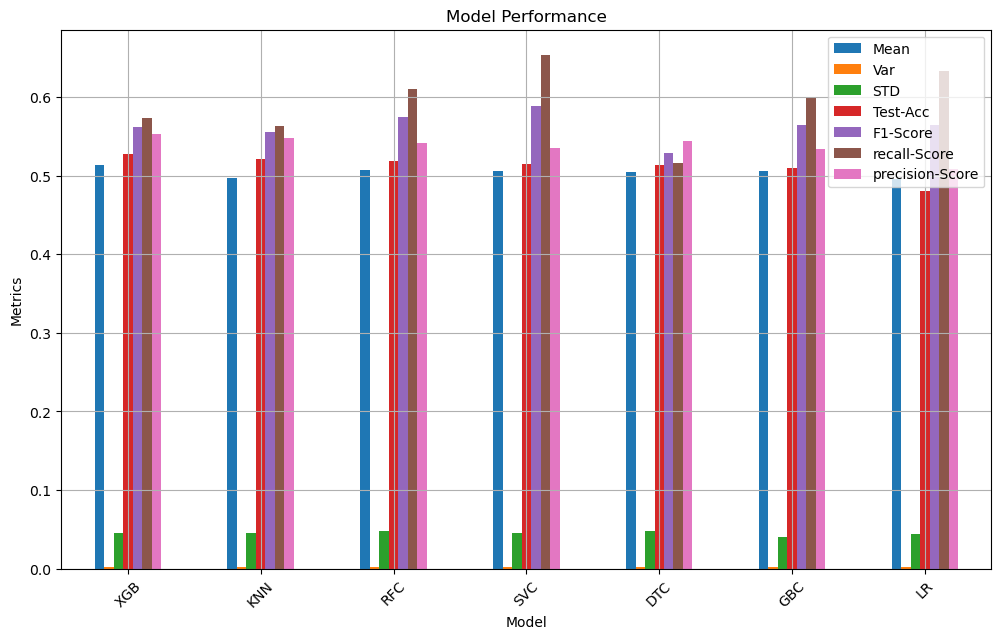

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      3   XGB  0.514  0.002  0.046     0.527     0.562         0.573   
1      0   KNN  0.497  0.002  0.046     0.521     0.555         0.563   
2      4   RFC  0.507  0.002  0.048     0.519     0.574         0.610   
3      1   SVC  0.506  0.002  0.046     0.515     0.589         0.653   
4      6   DTC  0.504  0.002  0.048     0.513     0.529         0.516   
5      5   GBC  0.506  0.002  0.040     0.510     0.565         0.599   
6      2    LR  0.496  0.002  0.044     0.480     0.564         0.633   

   precision-Score  
0            0.553  
1            0.548  
2            0.542  
3            0.535  
4            0.544  
5            0.534  
6            0.508  


In [57]:
model_names = ["KNN", "SVC", "LR", "XGB", "RFC", "GBC", "DTC"]
models = get_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, acc_metric, X, y)

# F1 Metric

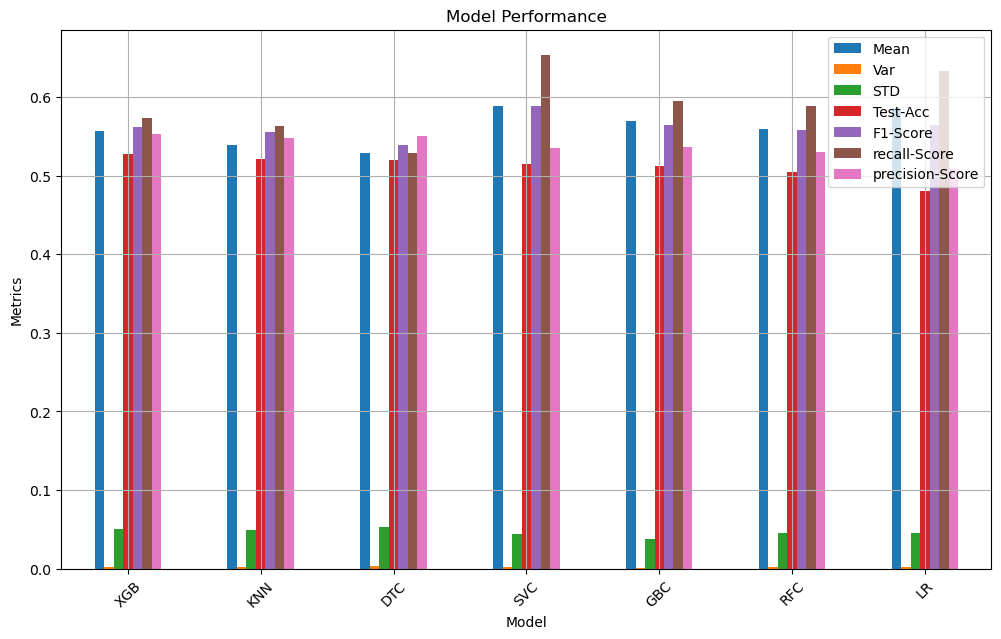

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      3   XGB  0.557  0.002  0.050     0.527     0.562         0.573   
1      0   KNN  0.539  0.002  0.049     0.521     0.555         0.563   
2      6   DTC  0.529  0.003  0.053     0.520     0.539         0.529   
3      1   SVC  0.588  0.002  0.044     0.515     0.589         0.653   
4      5   GBC  0.570  0.001  0.038     0.512     0.564         0.595   
5      4   RFC  0.559  0.002  0.046     0.504     0.558         0.589   
6      2    LR  0.586  0.002  0.046     0.480     0.564         0.633   

   precision-Score  
0            0.553  
1            0.548  
2            0.550  
3            0.535  
4            0.537  
5            0.530  
6            0.508  


In [58]:
test_selected_models(preprocessor, model_names, models, f1_metric, X, y)